In [189]:
import pandas as pd
import numpy as np
import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
pd.set_option('display.max_rows', 16)

import statsmodels.api as sm

In [190]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

In [191]:
ta.__version__

'0.4.17'

# Data

In [192]:
START = '20070101'
END = '20221231'

In [193]:
index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

In [194]:
index_id = index_info[index_info['secShortName'].isin(['上证综指','深证综指','创业板指','沪深300','中证500','中证1000'])].drop_duplicates('secShortName').secID.values
index_df = DataAPI.MktIdxdGet(indexID=index_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','openIndex','highestIndex','lowestIndex','closeIndex','turnoverVol','turnoverValue','CHGPct'],pandas="1")

In [195]:
index_df

indexID secShortName   tradeDate  openIndex  highestIndex  \
0      000001.ZICN         上证综指  2007-01-04   2728.188      2847.615   
1      000001.ZICN         上证综指  2007-01-05   2668.577      2685.804   
2      000001.ZICN         上证综指  2007-01-08   2621.068      2708.444   
3      000001.ZICN         上证综指  2007-01-09   2711.049      2809.394   
4      000001.ZICN         上证综指  2007-01-10   2838.113      2841.741   
5      000001.ZICN         上证综指  2007-01-11   2819.367      2841.180   
6      000001.ZICN         上证综指  2007-01-12   2745.321      2782.025   
7      000001.ZICN         上证综指  2007-01-15   2660.070      2795.331   
...            ...          ...         ...        ...           ...   
21391  399106.ZICN         深证综指  2022-03-18   2121.953      2150.580   
21392  399106.ZICN         深证综指  2022-03-21   2152.240      2170.287   
21393  399106.ZICN         深证综指  2022-03-22   2155.890      2166.647   
21394  399106.ZICN         深证综指  2022-03-23   2157.793      2170.057   
21395  399106.ZICN         深证综指  2022-03-24   2150.700      2158.295   
21396  399106.ZICN         深证综指  2022-03-25   2146.102      2152.020   
21397  399106.ZICN         深证综指  2022-03-28   2098.794      2114.635   
21398  399106.ZICN         深证综指  2022-03-29   2101.236      2109.786   

       lowestIndex  closeIndex  turnoverVol  turnoverValue    CHGPct  
0         2684.818    2715.719  12015602100   8.394553e+10  0.015042  
1         2617.019    2641.334  10615562500   7.012870e+10 -0.027391  
2         2620.625    2707.199  10681324400   7.216588e+10  0.024936  
3         2691.360    2807.804  11075126700   8.622197e+10  0.037162  
4         2770.988    2825.576  11176936500   7.905066e+10  0.006330  
5         2763.886    2770.110  12159871700   8.398673e+10 -0.019630  
6         2652.578    2668.110  10730376800   7.343404e+10 -0.036822  
7         2658.879    2794.701   9176156100   6.693948e+10  0.047446  
...            ...         ...          ...            ...       ...  
21391     2116.618    2144.901  45201628249   5.620501e+11  0.005576  
21392     2136.911    2160.538  47249131825   5.940692e+11  0.007290  
21393     2140.086    2151.682  46450150819   5.599974e+11 -0.004099  
21394     2147.801    2163.199  45067751249   5.373947e+11  0.005353  
21395     2127.387    2144.342  44069282709   5.293617e+11 -0.008717  
21396     2113.733    2113.733  43718468033   5.284918e+11 -0.014274  
21397     2075.709    2096.502  42333298775   4.959139e+11 -0.008152  
21398     2077.145    2084.473  42513225308   5.000129e+11 -0.005738  

[21399 rows x 10 columns]

In [196]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [197]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# Takes about 6 mins

In [198]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [199]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(9972182, 10)
(9572273, 10)


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

## 沪深300

In [200]:
hs300_df = index_df[index_df['secShortName']=='沪深300'].reset_index(drop=True)
hs300_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
hs300_df['open_ret'] = hs300_df['openIndex']/hs300_df['openIndex'].shift()-1
hs300_df

indexID secShortName   tradeDate  openIndex  highestIndex  \
0     000300.ZICN        沪深300  2007-01-04  2073.2500     2139.4900   
1     000300.ZICN        沪深300  2007-01-05  2051.1500     2083.4000   
2     000300.ZICN        沪深300  2007-01-08  2072.0000     2131.7400   
3     000300.ZICN        沪深300  2007-01-09  2137.4900     2201.3600   
4     000300.ZICN        沪深300  2007-01-10  2210.7600     2255.9700   
5     000300.ZICN        沪深300  2007-01-11  2257.0100     2289.9500   
6     000300.ZICN        沪深300  2007-01-12  2215.8600     2249.5400   
7     000300.ZICN        沪深300  2007-01-15  2170.9400     2287.6800   
...           ...          ...         ...        ...           ...   
3697  000300.ZICN        沪深300  2022-03-18  4218.4736     4283.3679   
3698  000300.ZICN        沪深300  2022-03-21  4280.1397     4287.8166   
3699  000300.ZICN        沪深300  2022-03-22  4252.5658     4283.3344   
3700  000300.ZICN        沪深300  2022-03-23  4269.6088     4287.5771   
3701  000300.ZICN        沪深300  2022-03-24  4249.5328     4273.9568   
3702  000300.ZICN        沪深300  2022-03-25  4249.0731     4254.8449   
3703  000300.ZICN        沪深300  2022-03-28  4128.8379     4174.1206   
3704  000300.ZICN        沪深300  2022-03-29  4155.4182     4177.2134   

      lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  open_ret  
0       2054.2400   2067.0900  10671970700   8.238107e+10   0.012758       NaN  
1       2030.7600   2072.8800   9274344700   6.802606e+10   0.002801 -0.010660  
2       2071.7200   2131.5600   8476790900   6.630394e+10   0.028308  0.010165  
3       2128.0600   2200.0900   8157762900   6.545619e+10   0.032150  0.031607  
4       2194.7700   2255.9700   8490497900   6.882262e+10   0.025399  0.034279  
5       2224.3700   2231.6300   8627654800   6.873001e+10  -0.010789  0.020920  
6       2159.7700   2173.7500   7652572000   6.174283e+10  -0.025936 -0.018232  
7       2170.9400   2287.3400   6640309700   5.704345e+10   0.052255 -0.020272  
...           ...         ...          ...            ...        ...       ...  
3697    4194.9402   4265.9017  14945830500   2.757913e+11   0.006656 -0.004530  
3698    4223.0240   4258.7459  12703636000   2.512145e+11  -0.001677  0.014618  
3699    4236.6888   4255.2950  12638247000   2.262135e+11  -0.000810 -0.006442  
3700    4241.9570   4276.5174  11708907800   2.263908e+11   0.004987  0.004008  
3701    4216.8506   4251.3061  10891827200   2.195944e+11  -0.005895 -0.004702  
3702    4173.9300   4174.5742  10880804600   2.170132e+11  -0.018049 -0.000108  
3703    4091.2978   4148.4663  11844902100   2.134690e+11  -0.006254 -0.028297  
3704    4124.7179   4134.1441  10026697200   1.994639e+11  -0.003452  0.006438  

[3705 rows x 11 columns]

In [201]:
hs300_df['close_ret_demean'] = hs300_df['close_ret'] - hs300_df['close_ret'].mean()
hs300_df['open_ret_demean'] = hs300_df['open_ret'] - hs300_df['open_ret'].mean()

In [202]:
(hs300_df['close_ret']- hs300_df['close_ret_demean']).describe()

count    3.705000e+03
mean     3.372008e-04
std      3.026228e-18
min      3.372008e-04
25%      3.372008e-04
50%      3.372008e-04
75%      3.372008e-04
max      3.372008e-04
dtype: float64

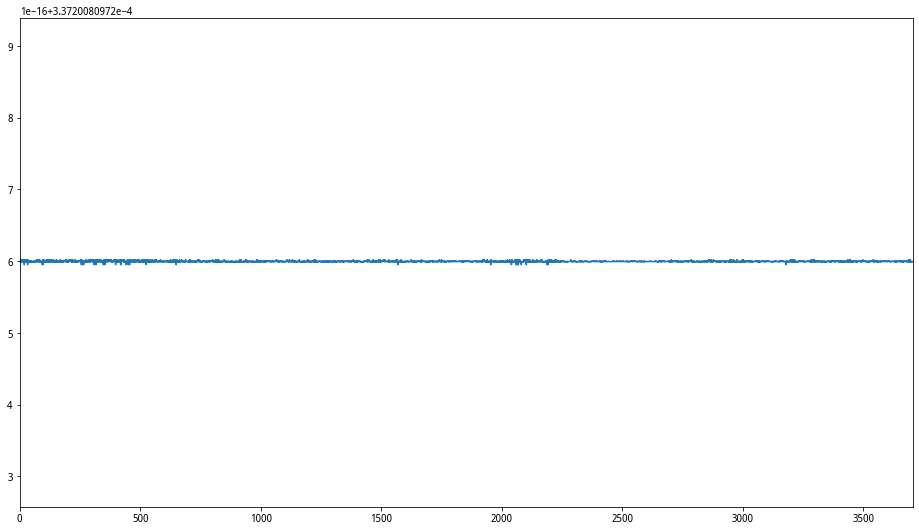

In [203]:
(hs300_df['close_ret']- hs300_df['close_ret_demean']).plot()

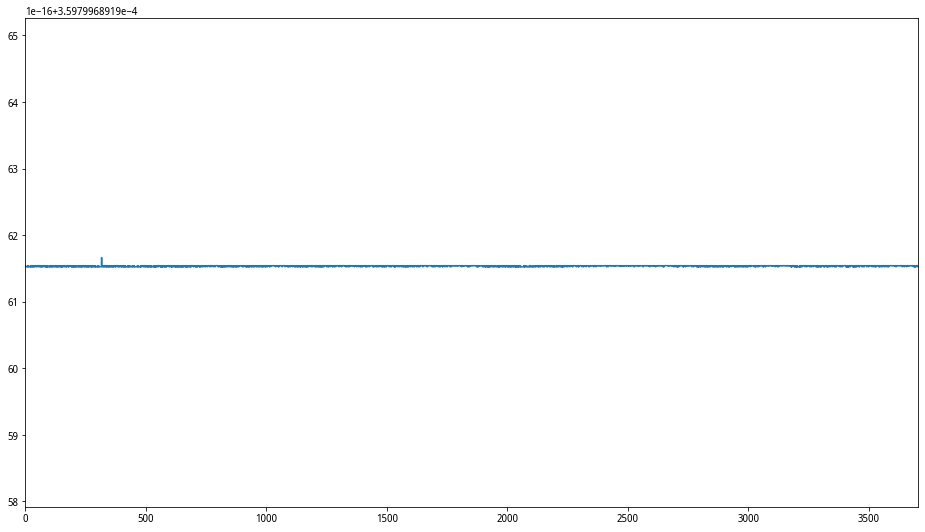

In [204]:
(hs300_df['open_ret']- hs300_df['open_ret_demean']).plot()

In [205]:
hs300_cols = hs300_df.columns

# Technical indicators

## Moving average

### MA30

In [206]:
ta.SMA?

Docstring:
SMA(real[, timeperiod=?])

Simple Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


In [207]:
ta.SMA(hs300_df['closeIndex'], 5)

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
3697    4163.64960
3698    4180.44724
3699    4234.74384
3700    4258.83112
3701    4261.55322
3702    4243.28772
3703    4221.23180
3704    4197.00162
Length: 3705, dtype: float64

In [208]:
hs300_df['closeIndex'].rolling(5).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
3697    4163.64960
3698    4180.44724
3699    4234.74384
3700    4258.83112
3701    4261.55322
3702    4243.28772
3703    4221.23180
3704    4197.00162
Name: closeIndex, Length: 3705, dtype: float64

In [209]:
MA_df = hs300_df.copy()
MA_df['MA30'] = ta.SMA(MA_df['closeIndex'], 30)

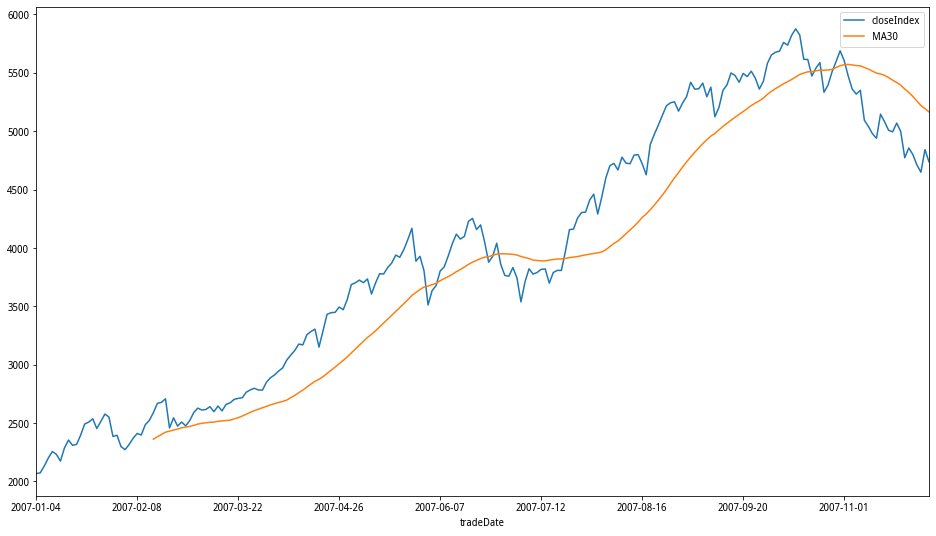

In [210]:
MA_df[['tradeDate','closeIndex','MA30']].set_index('tradeDate').loc[:'2007-12'].plot()

- 当收盘价高于均线时买入，低于均线时卖出

Case 1:
1. t日：收盘价高于MA30，假设可以以当日收盘价买入
2. t+k日：收盘价低于MA30，假设可以以当日收盘价卖出

Case 2:
1. t日：收盘价高于MA30，假设不能以当日收盘价买入。以次日开盘价买入
2. t+k日：收盘价低于MA30，假设不能以当日收盘价卖出。以次日开盘价卖出

In [212]:
MA_df['signal'] = np.nan
MA_df.loc[MA_df['closeIndex'] > MA_df['MA30'], 'signal'] = 1
MA_df.loc[MA_df['closeIndex'] < MA_df['MA30'], 'signal'] = 0

In [213]:
MA_df[~MA_df['signal'].isna()]

indexID secShortName   tradeDate  openIndex  highestIndex  \
29    000300.ZICN        沪深300  2007-02-14  2527.5600     2594.6600   
30    000300.ZICN        沪深300  2007-02-15  2607.6300     2669.1800   
31    000300.ZICN        沪深300  2007-02-16  2692.6700     2717.5700   
32    000300.ZICN        沪深300  2007-02-26  2679.2700     2710.3000   
33    000300.ZICN        沪深300  2007-02-27  2717.8100     2719.5200   
34    000300.ZICN        沪深300  2007-02-28  2413.4200     2554.2300   
35    000300.ZICN        沪深300  2007-03-01  2550.2600     2550.3300   
36    000300.ZICN        沪深300  2007-03-02  2468.6700     2523.8600   
...           ...          ...         ...        ...           ...   
3697  000300.ZICN        沪深300  2022-03-18  4218.4736     4283.3679   
3698  000300.ZICN        沪深300  2022-03-21  4280.1397     4287.8166   
3699  000300.ZICN        沪深300  2022-03-22  4252.5658     4283.3344   
3700  000300.ZICN        沪深300  2022-03-23  4269.6088     4287.5771   
3701  000300.ZICN        沪深300  2022-03-24  4249.5328     4273.9568   
3702  000300.ZICN        沪深300  2022-03-25  4249.0731     4254.8449   
3703  000300.ZICN        沪深300  2022-03-28  4128.8379     4174.1206   
3704  000300.ZICN        沪深300  2022-03-29  4155.4182     4177.2134   

      lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  \
29      2520.5300   2588.3500   6277727900   5.846227e+10   0.026052   
30      2607.6300   2668.6300   7163132900   6.741569e+10   0.031016   
31      2660.4900   2676.7400   7590878500   7.159758e+10   0.003039   
32      2641.1200   2707.6800   7453156000   7.098161e+10   0.011559   
33      2454.9200   2457.4900  10773680700   1.011028e+11  -0.092400   
34      2413.3300   2544.5700   8282257100   7.714825e+10   0.035435   
35      2439.5000   2473.5400   8215965500   7.429958e+10  -0.027914   
36      2455.8200   2508.7300   5794680500   5.422210e+10   0.014227   
...           ...         ...          ...            ...        ...   
3697    4194.9402   4265.9017  14945830500   2.757913e+11   0.006656   
3698    4223.0240   4258.7459  12703636000   2.512145e+11  -0.001677   
3699    4236.6888   4255.2950  12638247000   2.262135e+11  -0.000810   
3700    4241.9570   4276.5174  11708907800   2.263908e+11   0.004987   
3701    4216.8506   4251.3061  10891827200   2.195944e+11  -0.005895   
3702    4173.9300   4174.5742  10880804600   2.170132e+11  -0.018049   
3703    4091.2978   4148.4663  11844902100   2.134690e+11  -0.006254   
3704    4124.7179   4134.1441  10026697200   1.994639e+11  -0.003452   

      open_ret  close_ret_demean  open_ret_demean         MA30  signal  
29    0.011692          0.025715         0.011332  2362.236000     1.0  
30    0.031679          0.030679         0.031319  2382.287333     1.0  
31    0.032612          0.002702         0.032252  2402.416000     1.0  
32   -0.004976          0.011222        -0.005336  2421.620000     1.0  
33    0.014385         -0.092737         0.014025  2430.200000     1.0  
34   -0.111998          0.035098        -0.112358  2439.820000     1.0  
35    0.056700         -0.028251         0.056340  2447.883667     1.0  
36   -0.031993          0.013890        -0.032353  2459.049667     1.0  
...        ...               ...              ...          ...     ...  
3697 -0.004530          0.006319        -0.004890  4473.691060     0.0  
3698  0.014618         -0.002014         0.014258  4461.179593     0.0  
3699 -0.006442         -0.001147        -0.006802  4449.396997     0.0  
3700  0.004008          0.004650         0.003648  4436.878880     0.0  
3701 -0.004702         -0.006232        -0.005062  4423.927000     0.0  
3702 -0.000108         -0.018386        -0.000468  4409.699630     0.0  
3703 -0.028297         -0.006591        -0.028657  4396.258913     0.0  
3704  0.006438         -0.003789         0.006078  4380.726967     0.0  

[3676 rows x 15 columns]

In [214]:
MA_df['position_close'] = MA_df['signal']
MA_df['position_open'] = MA_df['signal'].shift()

In [215]:
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

In [216]:
MA_df['MA30_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df['MA30_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()

In [217]:
MA_df['signal'].unique()

array([nan,  1.,  0.])

In [218]:
MA_df[MA_df['signal']==0]

indexID secShortName   tradeDate  openIndex  highestIndex  \
97    000300.ZICN        沪深300  2007-06-04  3804.9600     3822.4100   
98    000300.ZICN        沪深300  2007-06-05  3407.0000     3635.1500   
99    000300.ZICN        沪深300  2007-06-06  3652.8900     3712.5300   
112   000300.ZICN        沪深300  2007-06-25  4066.4500     4105.9900   
113   000300.ZICN        沪深300  2007-06-26  3804.4100     3929.3700   
115   000300.ZICN        沪深300  2007-06-28  4038.3800     4067.8100   
116   000300.ZICN        沪深300  2007-06-29  3769.3300     3867.7500   
117   000300.ZICN        沪深300  2007-07-02  3746.1800     3801.9000   
...           ...          ...         ...        ...           ...   
3697  000300.ZICN        沪深300  2022-03-18  4218.4736     4283.3679   
3698  000300.ZICN        沪深300  2022-03-21  4280.1397     4287.8166   
3699  000300.ZICN        沪深300  2022-03-22  4252.5658     4283.3344   
3700  000300.ZICN        沪深300  2022-03-23  4269.6088     4287.5771   
3701  000300.ZICN        沪深300  2022-03-24  4249.5328     4273.9568   
3702  000300.ZICN        沪深300  2022-03-25  4249.0731     4254.8449   
3703  000300.ZICN        沪深300  2022-03-28  4128.8379     4174.1206   
3704  000300.ZICN        沪深300  2022-03-29  4155.4182     4177.2134   

      lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  ...  \
97      3503.9400   3511.4300   9053101900   1.312962e+11  -0.076899  ...   
98      3246.7300   3634.6300  11376803800   1.507649e+11   0.035085  ...   
99      3550.7400   3677.5800   9595151000   1.359385e+11   0.011817  ...   
112     3850.8400   3877.5900   7003104400   1.134327e+11  -0.042908  ...   
113     3752.9300   3928.2100   5888511400   8.786774e+10   0.013055  ...   
115     3857.8500   3858.5200   6685798000   9.837205e+10  -0.045034  ...   
116     3718.1600   3764.0800   5892087000   8.852759e+10  -0.024476  ...   
117     3644.1900   3757.6600   4974731000   7.199587e+10  -0.001706  ...   
...           ...         ...          ...            ...        ...  ...   
3697    4194.9402   4265.9017  14945830500   2.757913e+11   0.006656  ...   
3698    4223.0240   4258.7459  12703636000   2.512145e+11  -0.001677  ...   
3699    4236.6888   4255.2950  12638247000   2.262135e+11  -0.000810  ...   
3700    4241.9570   4276.5174  11708907800   2.263908e+11   0.004987  ...   
3701    4216.8506   4251.3061  10891827200   2.195944e+11  -0.005895  ...   
3702    4173.9300   4174.5742  10880804600   2.170132e+11  -0.018049  ...   
3703    4091.2978   4148.4663  11844902100   2.134690e+11  -0.006254  ...   
3704    4124.7179   4134.1441  10026697200   1.994639e+11  -0.003452  ...   

             MA30  signal  position_close  position_open  position_close_ret  \
97    3673.361667     0.0             0.0            1.0           -0.076899   
98    3685.062667     0.0             0.0            0.0            0.000000   
99    3697.498667     0.0             0.0            0.0            0.000000   
112   3925.166667     0.0             0.0            1.0           -0.042908   
113   3935.952333     0.0             0.0            0.0            0.000000   
115   3949.955667     0.0             0.0            1.0           -0.045034   
116   3949.537333     0.0             0.0            0.0           -0.000000   
117   3947.078000     0.0             0.0            0.0           -0.000000   
...           ...     ...             ...            ...                 ...   
3697  4473.691060     0.0             0.0            0.0            0.000000   
3698  4461.179593     0.0             0.0            0.0           -0.000000   
3699  4449.396997     0.0             0.0            0.0           -0.000000   
3700  4436.878880     0.0             0.0            0.0            0.000000   
3701  4423.927000     0.0             0.0            0.0           -0.000000   
3702  4409.699630     0.0             0.0            0.0           -0.000000   
3703  4396.258913     0.0             0.0            0.0        

In [219]:
MA_df.loc[96:99]

indexID secShortName   tradeDate  openIndex  highestIndex  \
96  000300.ZICN        沪深300  2007-06-01    3953.10       4014.15   
97  000300.ZICN        沪深300  2007-06-04    3804.96       3822.41   
98  000300.ZICN        沪深300  2007-06-05    3407.00       3635.15   
99  000300.ZICN        沪深300  2007-06-06    3652.89       3712.53   

    lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  ...  \
96      3780.03     3803.95  11993793900   1.939803e+11  -0.031569  ...   
97      3503.94     3511.43   9053101900   1.312962e+11  -0.076899  ...   
98      3246.73     3634.63  11376803800   1.507649e+11   0.035085  ...   
99      3550.74     3677.58   9595151000   1.359385e+11   0.011817  ...   

           MA30  signal  position_close  position_open  position_close_ret  \
96  3664.847333     1.0             1.0            1.0           -0.031569   
97  3673.361667     0.0             0.0            1.0           -0.076899   
98  3685.062667     0.0             0.0            0.0            0.000000   
99  3697.498667     0.0             0.0            0.0            0.000000   

    position_open_ret  position_close_ret_demean  position_open_ret_demean  \
96           0.032432                  -0.031906                  0.032072   
97          -0.037474                  -0.077236                 -0.037834   
98          -0.104590                   0.000000                 -0.104950   
99           0.000000                   0.000000                  0.000000   

    MA30_close_cumret  MA30_open_cumret  
96           1.469641          1.515974  
97           1.356627          1.459164  
98           1.356627          1.306550  
99           1.356627          1.306550  

[4 rows x 23 columns]

In [220]:
3511.43/3803.95 - 1

-0.07689901286820278

In [32]:
3407.00 / 3804.96 - 1

-0.10458979857869732

In [221]:
## Example
temp = MA_df.loc[99:113,['tradeDate','openIndex','closeIndex','close_ret','open_ret','signal',
                        'position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean']].copy()
temp['MA30_close_cumret'] = (temp['position_close_ret']+1).cumprod()
temp['MA30_open_cumret'] = (temp['position_open_ret']+1).cumprod()

display(temp)

# close 
print(3877.59 / 3802.30)

# open
print(3804.41 / 3814.19)

tradeDate  openIndex  closeIndex  close_ret  open_ret  signal  \
99   2007-06-06    3652.89     3677.58   0.011817  0.072172     0.0   
100  2007-06-07    3694.55     3802.30   0.033914  0.011405     1.0   
101  2007-06-08    3814.19     3837.87   0.009355  0.032383     1.0   
102  2007-06-11    3876.07     3931.86   0.024490  0.016224     1.0   
103  2007-06-12    3953.96     4036.11   0.026514  0.020095     1.0   
104  2007-06-13    4071.74     4118.27   0.020356  0.029788     1.0   
105  2007-06-14    4103.52     4075.82  -0.010308  0.007805     1.0   
106  2007-06-15    4043.11     4099.38   0.005780 -0.014722     1.0   
107  2007-06-18    4178.76     4227.57   0.031271  0.033551     1.0   
108  2007-06-19    4227.59     4253.00   0.006015  0.011685     1.0   
109  2007-06-20    4268.65     4157.60  -0.022431  0.009712     1.0   
110  2007-06-21    4140.69     4197.28   0.009544 -0.029977     1.0   
111  2007-06-22    4203.13     4051.43  -0.034749  0.015080     1.0   
112  2007-06-25    4066.45     3877.59  -0.042908 -0.032519     0.0   
113  2007-06-26    3804.41     3928.21   0.013055 -0.064439     0.0   

     position_close  position_open  position_close_ret  position_open_ret  \
99              0.0            0.0            0.000000           0.000000   
100             1.0            0.0            0.000000           0.000000   
101             1.0            1.0            0.009355           0.000000   
102             1.0            1.0            0.024490           0.016224   
103             1.0            1.0            0.026514           0.020095   
104             1.0            1.0            0.020356           0.029788   
105             1.0            1.0           -0.010308           0.007805   
106             1.0            1.0            0.005780          -0.014722   
107             1.0            1.0            0.031271           0.033551   
108             1.0            1.0            0.006015           0.011685   
109             1.0            1.0           -0.022431           0.009712   
110             1.0            1.0            0.009544          -0.029977   
111             1.0            1.0           -0.034749           0.015080   
112             0.0            1.0           -0.042908          -0.032519   
113             0.0            0.0            0.000000          -0.064439   

     position_close_ret_demean  position_open_ret_demean  MA30_close_cumret  \
99                    0.000000                  0.000000           1.000000   
100                   0.000000                  0.000000           1.000000   
101                   0.009018                  0.000000           1.009355   
102                   0.024153                  0.015864           1.034074   
103                   0.026177                  0.019735           1.061492   
104                   0.020019                  0.029428           1.083099   
105                  -0.010645                  0.007445           1.071935   
106                   0.005443                 -0.015081           1.078130   
107                   0.030934                  0.033191           1.111845   
108                   0.005678                  0.011325           1.118532   
109                  -0.022768                  0.009353           1.093443   
110                   0.009207                 -0.030336           1.103878   
111                  -0.035086                  0.014720           1.065520   
112                  -0.043245                 -0.032878           1.019800   
113                   0.000000                 -0.064799           1.019800   

     MA30_open_cumret  
99           1.000000  
100          1.000000  
101          1.000000  
102          1.016224  
103          1.036645  
104          1.067524  
105          1.075856  
106          1.060018  
107          1.095583  
108          1.108385  
109          1.119150  
110          1.085601  
111          1.101972  
112          1.066137  
113        

1.0198011729742524
0.9974358907133625


In [222]:
MA30_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MA30',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        'MA30_close_cumret','MA30_open_cumret']].copy()

In [223]:
MA30_ret_df.set_index('tradeDate',inplace=True)

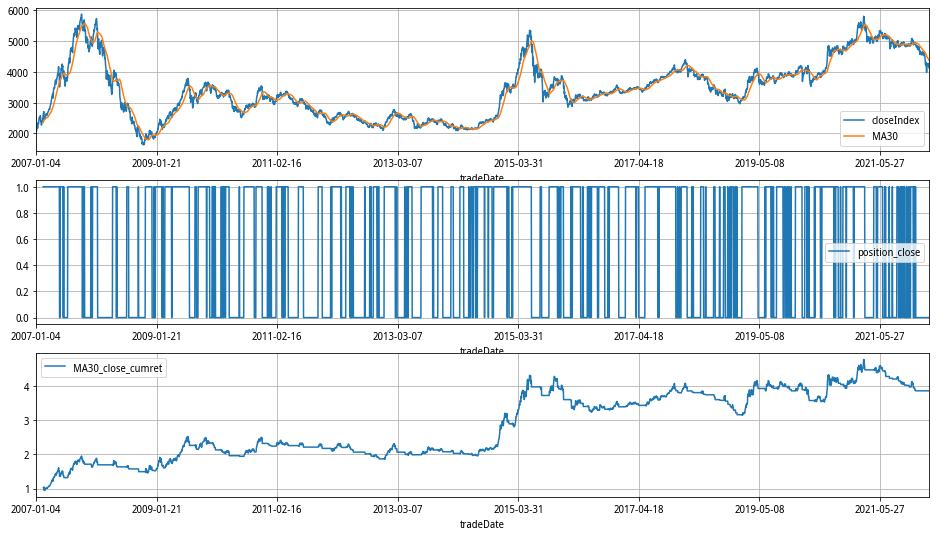

In [224]:
# Close price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['closeIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA30_ret_df[['MA30_close_cumret']].plot(ax=axes[2],grid=True)

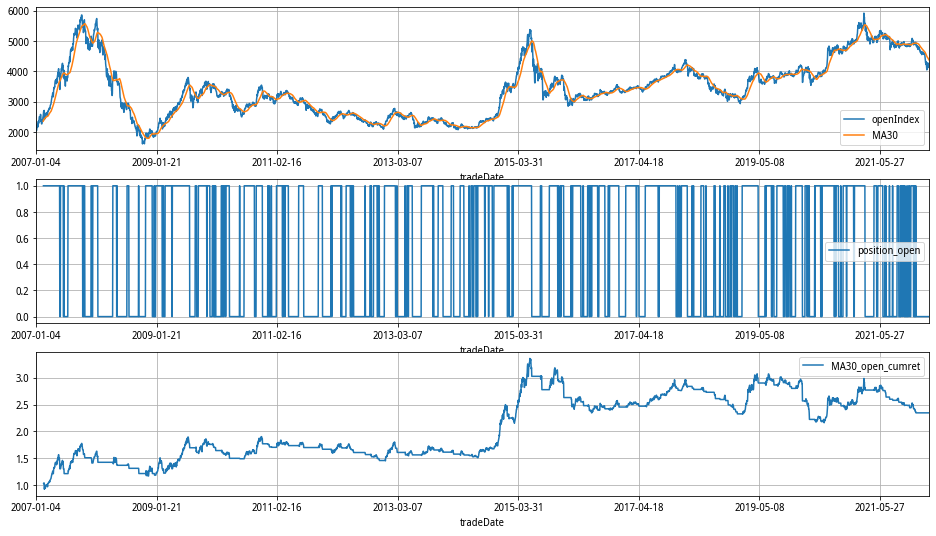

In [225]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['openIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MA30_ret_df[['MA30_open_cumret']].plot(ax=axes[2], grid=True)

### MA20

In [226]:
hs300_df

indexID secShortName   tradeDate  openIndex  highestIndex  \
0     000300.ZICN        沪深300  2007-01-04  2073.2500     2139.4900   
1     000300.ZICN        沪深300  2007-01-05  2051.1500     2083.4000   
2     000300.ZICN        沪深300  2007-01-08  2072.0000     2131.7400   
3     000300.ZICN        沪深300  2007-01-09  2137.4900     2201.3600   
4     000300.ZICN        沪深300  2007-01-10  2210.7600     2255.9700   
5     000300.ZICN        沪深300  2007-01-11  2257.0100     2289.9500   
6     000300.ZICN        沪深300  2007-01-12  2215.8600     2249.5400   
7     000300.ZICN        沪深300  2007-01-15  2170.9400     2287.6800   
...           ...          ...         ...        ...           ...   
3697  000300.ZICN        沪深300  2022-03-18  4218.4736     4283.3679   
3698  000300.ZICN        沪深300  2022-03-21  4280.1397     4287.8166   
3699  000300.ZICN        沪深300  2022-03-22  4252.5658     4283.3344   
3700  000300.ZICN        沪深300  2022-03-23  4269.6088     4287.5771   
3701  000300.ZICN        沪深300  2022-03-24  4249.5328     4273.9568   
3702  000300.ZICN        沪深300  2022-03-25  4249.0731     4254.8449   
3703  000300.ZICN        沪深300  2022-03-28  4128.8379     4174.1206   
3704  000300.ZICN        沪深300  2022-03-29  4155.4182     4177.2134   

      lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  \
0       2054.2400   2067.0900  10671970700   8.238107e+10   0.012758   
1       2030.7600   2072.8800   9274344700   6.802606e+10   0.002801   
2       2071.7200   2131.5600   8476790900   6.630394e+10   0.028308   
3       2128.0600   2200.0900   8157762900   6.545619e+10   0.032150   
4       2194.7700   2255.9700   8490497900   6.882262e+10   0.025399   
5       2224.3700   2231.6300   8627654800   6.873001e+10  -0.010789   
6       2159.7700   2173.7500   7652572000   6.174283e+10  -0.025936   
7       2170.9400   2287.3400   6640309700   5.704345e+10   0.052255   
...           ...         ...          ...            ...        ...   
3697    4194.9402   4265.9017  14945830500   2.757913e+11   0.006656   
3698    4223.0240   4258.7459  12703636000   2.512145e+11  -0.001677   
3699    4236.6888   4255.2950  12638247000   2.262135e+11  -0.000810   
3700    4241.9570   4276.5174  11708907800   2.263908e+11   0.004987   
3701    4216.8506   4251.3061  10891827200   2.195944e+11  -0.005895   
3702    4173.9300   4174.5742  10880804600   2.170132e+11  -0.018049   
3703    4091.2978   4148.4663  11844902100   2.134690e+11  -0.006254   
3704    4124.7179   4134.1441  10026697200   1.994639e+11  -0.003452   

      open_ret  close_ret_demean  open_ret_demean  
0          NaN          0.012421              NaN  
1    -0.010660          0.002464        -0.011019  
2     0.010165          0.027971         0.009805  
3     0.031607          0.031813         0.031247  
4     0.034279          0.025062         0.033919  
5     0.020920         -0.011126         0.020561  
6    -0.018232         -0.026273        -0.018592  
7    -0.020272          0.051918        -0.020632  
...        ...               ...              ...  
3697 -0.004530          0.006319        -0.004890  
3698  0.014618         -0.002014         0.014258  
3699 -0.006442         -0.001147        -0.006802  
3700  0.004008          0.004650         0.003648  
3701 -0.004702         -0.006232        -0.005062  
3702 -0.000108         -0.018386        -0.000468  
3703 -0.028297         -0.006591        -0.028657  
3704  0.006438         -0.003789         0.006078  

[3705 rows x 13 columns]

In [227]:
MA_df = hs300_df.copy()

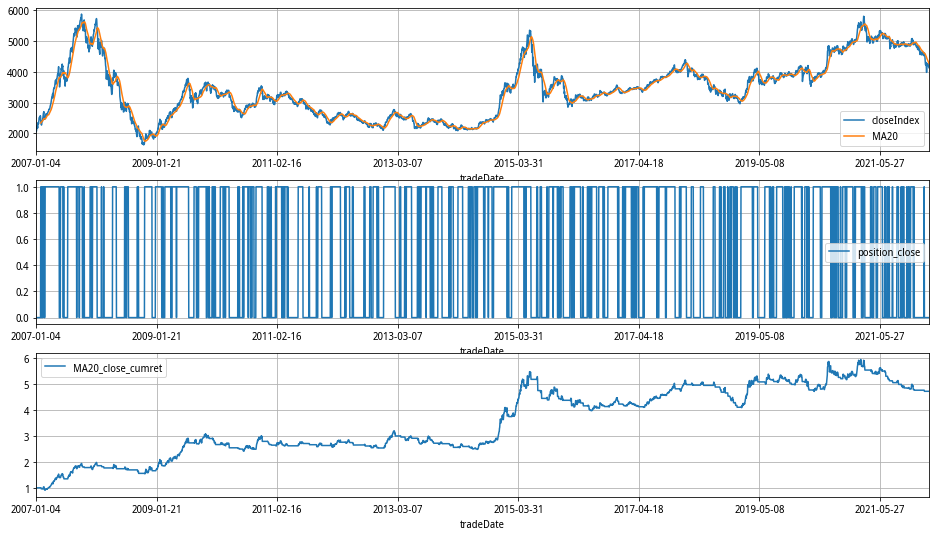

In [228]:
ma_length = 20

MA_df[f'MA{ma_length}'] = ta.SMA(MA_df['closeIndex'], ma_length)
MA_df['signal'] = 0
ndays = MA_df.shape[0]
MA_df.loc[MA_df['closeIndex'] > MA_df[f'MA{ma_length}'], 'signal'] = 1
MA_df['open_ret'] = MA_df['openIndex']/MA_df['openIndex'].shift()-1
MA_df['position_close'] = MA_df['signal']
MA_df['position_open'] = MA_df['signal'].shift()
MA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MA_df['position_close'] = MA_df['signal']
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

MA_df[f'MA{ma_length}_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df[f'MA{ma_length}_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()
MA_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret',f'MA{ma_length}',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        f'MA{ma_length}_close_cumret',f'MA{ma_length}_open_cumret']].copy()
MA_ret_df.set_index('tradeDate',inplace=True)
# Close price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['closeIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_close_cumret']].plot(ax=axes[2],grid=True)

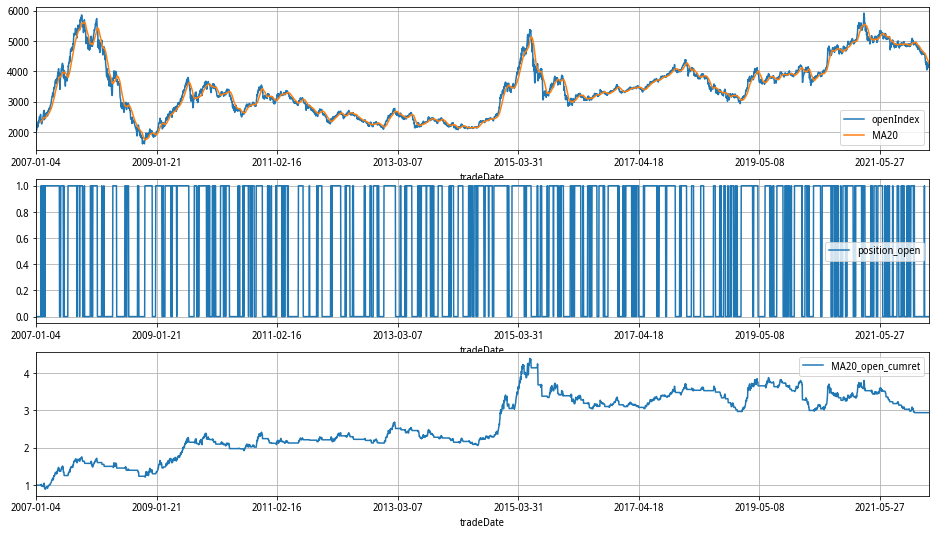

In [229]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['openIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_open']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_open_cumret']].plot(ax=axes[2],grid=True)

## Exponential moving average

In [230]:
ta.EMA?

Docstring:
EMA(real[, timeperiod=?])

Exponential Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


\begin{aligned}
E M A_{\text {Today }}=&\left(\text { Value }_{\text {Today }} *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) \\
&+E M A_{\text {Yesterday }} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)
\end{aligned}

Smoothing = 2

### EMA20

In [231]:
ema_length = 20
EMA_df = hs300_df.copy()
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)

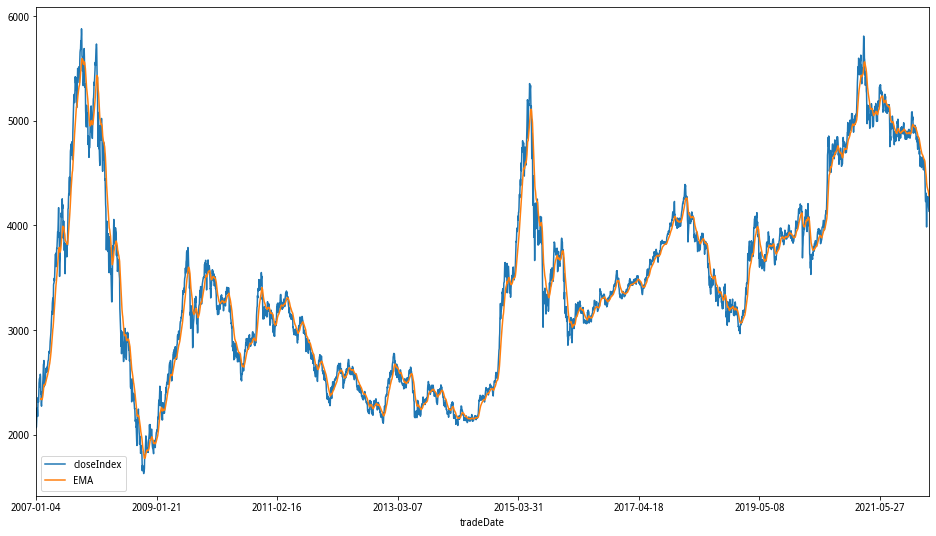

In [232]:
EMA_df[['tradeDate','closeIndex','EMA']].set_index('tradeDate').plot()

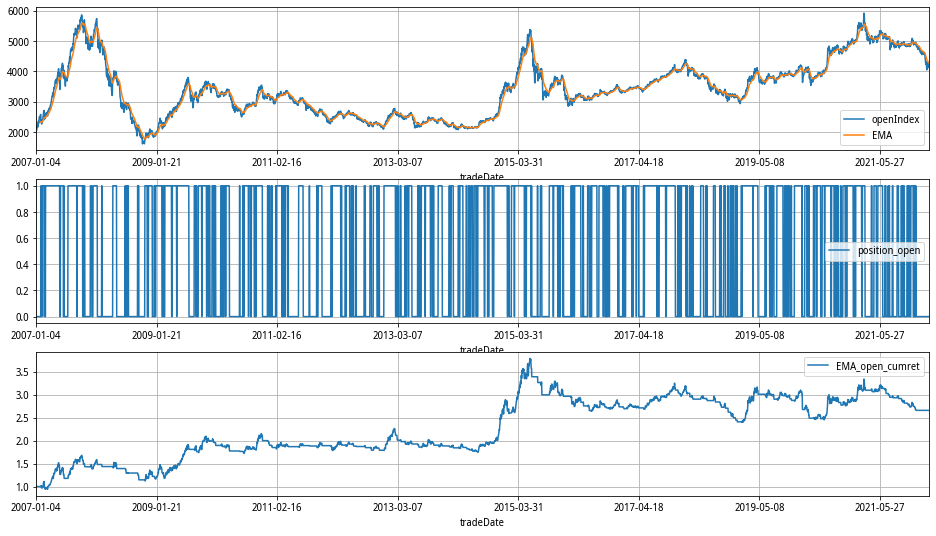

In [233]:
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)
EMA_df['signal'] = 0
EMA_df.loc[EMA_df['closeIndex'] > EMA_df['EMA'], 'signal'] = 1
EMA_df['open_ret'] = EMA_df['openIndex']/EMA_df['openIndex'].shift()-1
EMA_df['position_close'] = EMA_df['signal']
EMA_df['position_open'] = EMA_df['signal'].shift()
EMA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
EMA_df['position_close_ret'] = EMA_df['position_close'].shift() * EMA_df['close_ret']
EMA_df['position_open_ret'] = EMA_df['position_open'].shift() * EMA_df['open_ret']
EMA_df['position_close_ret_demean'] = EMA_df['position_close'].shift() * EMA_df['close_ret_demean']
EMA_df['position_open_ret_demean'] = EMA_df['position_open'].shift() * EMA_df['open_ret_demean']
EMA_df['EMA_close_cumret'] = (EMA_df['position_close_ret']+1).cumprod()
EMA_df['EMA_open_cumret'] = (EMA_df['position_open_ret']+1).cumprod()
EMA_ret_df = EMA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','EMA',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'EMA_close_cumret','EMA_open_cumret']].copy()
EMA_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
EMA_ret_df[['openIndex','EMA']].plot(ax=axes[0], grid=True)
EMA_ret_df[['position_open']].plot(ax=axes[1], grid=True)
EMA_ret_df[['EMA_open_cumret']].plot(ax=axes[2], grid=True)

In [234]:
EMA_ret_df

openIndex  closeIndex  open_ret  close_ret          EMA  signal  \
tradeDate                                                                     
2007-01-04  2073.2500   2067.0900       NaN   0.012758          NaN       0   
2007-01-05  2051.1500   2072.8800 -0.010660   0.002801          NaN       0   
2007-01-08  2072.0000   2131.5600  0.010165   0.028308          NaN       0   
2007-01-09  2137.4900   2200.0900  0.031607   0.032150          NaN       0   
2007-01-10  2210.7600   2255.9700  0.034279   0.025399          NaN       0   
2007-01-11  2257.0100   2231.6300  0.020920  -0.010789          NaN       0   
2007-01-12  2215.8600   2173.7500 -0.018232  -0.025936          NaN       0   
2007-01-15  2170.9400   2287.3400 -0.020272   0.052255          NaN       0   
...               ...         ...       ...        ...          ...     ...   
2022-03-18  4218.4736   4265.9017 -0.004530   0.006656  4360.013860       0   
2022-03-21  4280.1397   4258.7459  0.014618  -0.001677  4350.369293       0   
2022-03-22  4252.5658   4255.2950 -0.006442  -0.000810  4341.314598       0   
2022-03-23  4269.6088   4276.5174  0.004008   0.004987  4335.143436       0   
2022-03-24  4249.5328   4251.3061 -0.004702  -0.005895  4327.158928       0   
2022-03-25  4249.0731   4174.5742 -0.000108  -0.018049  4312.627049       0   
2022-03-28  4128.8379   4148.4663 -0.028297  -0.006254  4296.992692       0   
2022-03-29  4155.4182   4134.1441  0.006438  -0.003452  4281.483302       0   

            position_close  position_open  position_close_ret  \
tradeDate                                                       
2007-01-04               0            NaN                 NaN   
2007-01-05               0            0.0                 0.0   
2007-01-08               0            0.0                 0.0   
2007-01-09               0            0.0                 0.0   
2007-01-10               0            0.0                 0.0   
2007-01-11               0            0.0                -0.0   
2007-01-12               0            0.0                -0.0   
2007-01-15               0            0.0                 0.0   
...                    ...            ...                 ...   
2022-03-18               0            0.0                 0.0   
2022-03-21               0            0.0                -0.0   
2022-03-22               0            0.0                -0.0   
2022-03-23               0            0.0                 0.0   
2022-03-24               0            0.0                -0.0   
2022-03-25               0            0.0                -0.0   
2022-03-28               0            0.0                -0.0   
2022-03-29               0            0.0                -0.0   

            position_open_ret  position_close_ret_demean  \
tradeDate                                                  
2007-01-04                NaN                        NaN   
2007-01-05                NaN                        0.0   
2007-01-08                0.0                        0.0   
2007-01-09                0.0                        0.0   
2007-01-10                0.0                        0.0   
2007-01-11                0.0                       -0.0   
2007-01-12               -0.0                       -0.0   
2007-01-15               -0.0                        0.0   
...                       ...                        ...   
2022-03-18               -0.0                        0.0   
2022-03-21                0.0                       -0.0   
2022-03-22               -0.0                       -0.0   
2022-03-23                0.0                        0.0   
2022-03-24               -0.0                       -0.0   
2022-03-25               -0.0                       -0.0   
2022-03-28               -0.0                       -0.0   
2022-03-29                0.0                       -0.0   

            position_open_ret_demean  EMA_close_cumret  EMA_open_cumret  
tradeDate                                                  

# Statistical Inferences

## Cross-sectional test

In [235]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

In [236]:
ema_length = 20

In [237]:
stk_df

secID  tradeDate  preClosePrice  closePrice  openPrice  \
85       000001.XSHE 2007-06-20        824.193     987.007   1044.285   
86       000001.XSHE 2007-06-21        987.007    1085.740   1026.564   
87       000001.XSHE 2007-06-22       1085.740    1120.233   1126.562   
88       000001.XSHE 2007-06-25       1120.233    1113.904   1139.536   
89       000001.XSHE 2007-06-27       1113.904    1019.602   1002.513   
90       000001.XSHE 2007-06-28       1019.602     953.780    996.817   
91       000001.XSHE 2007-06-29        953.780     870.870    943.021   
92       000001.XSHE 2007-07-02        870.870     867.073    848.402   
...              ...        ...            ...         ...        ...   
9972174  900957.XSHG 2022-03-15          0.594       0.539      0.592   
9972175  900957.XSHG 2022-03-16          0.539       0.575      0.549   
9972176  900957.XSHG 2022-03-17          0.575       0.578      0.580   
9972177  900957.XSHG 2022-03-18          0.578       0.580      0.578   
9972178  900957.XSHG 2022-03-21          0.580       0.583      0.584   
9972179  900957.XSHG 2022-03-22          0.583       0.578      0.578   
9972180  900957.XSHG 2022-03-23          0.578       0.581      0.578   
9972181  900957.XSHG 2022-03-24          0.581       0.583      0.585   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  \
85           1053.778      970.235    4.835036e+10   4.182345e+09   
86           1085.740      988.906    5.318694e+10   2.285485e+09   
87           1132.891     1069.601    5.487665e+10   2.761567e+09   
88           1157.574     1087.005    5.456661e+10   2.324186e+09   
89           1069.284     1002.513    4.994705e+10   2.446556e+09   
90           1024.348      950.299    4.672266e+10   1.617434e+09   
91            948.717      861.377    4.266117e+10   1.410758e+09   
92            881.629      840.807    4.247515e+10   8.756147e+08   
...               ...          ...             ...            ...   
9972174         0.592        0.539    9.844000e+07   3.858820e+05   
9972175         0.580        0.549    1.048800e+08   3.278910e+05   
9972176         0.589        0.575    1.054320e+08   1.566370e+05   
9972177         0.580        0.575    1.058000e+08   3.270200e+04   
9972178         0.584        0.576    1.063520e+08   5.280900e+04   
9972179         0.583        0.575    1.054320e+08   8.467200e+04   
9972180         0.585        0.578    1.059840e+08   4.250300e+04   
9972181         0.585        0.579    1.063520e+08   1.823400e+04   

         turnoverRate  
85             0.0840  
86             0.0440  
87             0.0510  
88             0.0426  
89             0.0489  
90             0.0336  
91             0.0316  
92             0.0209  
...               ...  
9972174        0.0037  
9972175        0.0032  
9972176        0.0015  
9972177        0.0003  
9972178        0.0005  
9972179        0.0008  
9972180        0.0004  
9972181        0.0002  

[9572273 rows x 10 columns]

In [238]:
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)

In [239]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)

In [240]:
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1


In [241]:
stk_df['signal'] = 0
stk_df.loc[stk_df['closePrice'] > stk_df['EMA'], 'signal'] = 1

In [242]:
stk_df

secID  tradeDate  preClosePrice  closePrice  openPrice  \
85       000001.XSHE 2007-06-20        824.193     987.007   1044.285   
86       000001.XSHE 2007-06-21        987.007    1085.740   1026.564   
87       000001.XSHE 2007-06-22       1085.740    1120.233   1126.562   
88       000001.XSHE 2007-06-25       1120.233    1113.904   1139.536   
89       000001.XSHE 2007-06-27       1113.904    1019.602   1002.513   
90       000001.XSHE 2007-06-28       1019.602     953.780    996.817   
91       000001.XSHE 2007-06-29        953.780     870.870    943.021   
92       000001.XSHE 2007-07-02        870.870     867.073    848.402   
...              ...        ...            ...         ...        ...   
9972174  900957.XSHG 2022-03-15          0.594       0.539      0.592   
9972175  900957.XSHG 2022-03-16          0.539       0.575      0.549   
9972176  900957.XSHG 2022-03-17          0.575       0.578      0.580   
9972177  900957.XSHG 2022-03-18          0.578       0.580      0.578   
9972178  900957.XSHG 2022-03-21          0.580       0.583      0.584   
9972179  900957.XSHG 2022-03-22          0.583       0.578      0.578   
9972180  900957.XSHG 2022-03-23          0.578       0.581      0.578   
9972181  900957.XSHG 2022-03-24          0.581       0.583      0.585   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  \
85           1053.778      970.235    4.835036e+10   4.182345e+09   
86           1085.740      988.906    5.318694e+10   2.285485e+09   
87           1132.891     1069.601    5.487665e+10   2.761567e+09   
88           1157.574     1087.005    5.456661e+10   2.324186e+09   
89           1069.284     1002.513    4.994705e+10   2.446556e+09   
90           1024.348      950.299    4.672266e+10   1.617434e+09   
91            948.717      861.377    4.266117e+10   1.410758e+09   
92            881.629      840.807    4.247515e+10   8.756147e+08   
...               ...          ...             ...            ...   
9972174         0.592        0.539    9.844000e+07   3.858820e+05   
9972175         0.580        0.549    1.048800e+08   3.278910e+05   
9972176         0.589        0.575    1.054320e+08   1.566370e+05   
9972177         0.580        0.575    1.058000e+08   3.270200e+04   
9972178         0.584        0.576    1.063520e+08   5.280900e+04   
9972179         0.583        0.575    1.054320e+08   8.467200e+04   
9972180         0.585        0.578    1.059840e+08   4.250300e+04   
9972181         0.585        0.579    1.063520e+08   1.823400e+04   

         turnoverRate       EMA  open_ret  close_ret  signal  
85             0.0840       NaN       NaN   0.197544       0  
86             0.0440       NaN -0.016970   0.100033       0  
87             0.0510       NaN  0.097410   0.031769       0  
88             0.0426       NaN  0.011516  -0.005650       0  
89             0.0489       NaN -0.120245  -0.084659       0  
90             0.0336       NaN -0.005682  -0.064557       0  
91             0.0316       NaN -0.053968  -0.086928       0  
92             0.0209       NaN -0.100336  -0.004360       0  
...               ...       ...       ...        ...     ...  
9972174        0.0037  0.605024 -0.019868  -0.092593       0  
9972175        0.0032  0.602165 -0.072635   0.066790       0  
9972176        0.0015  0.599863  0.056466   0.005217       0  
9972177        0.0003  0.597972 -0.003448   0.003460       0  
9972178        0.0005  0.596546  0.010381   0.005172       0  
9972179        0.0008  0.594780 -0.010274  -0.008576       0  
9972180        0.0004  0.593467  0.000000   0.005190       0  
9972181        0.0002  0.592470  0.012111   0.003442       0  

[9572273 rows x 14 columns]

In [56]:
# %%time
# rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 51 s, sys: 7.58 s, total: 58.6 s
Wall time: 58.5 s


In [243]:
rule_ret_df.reset_index(inplace=True)

In [58]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [247]:
rule_ret_df

secID  position_open_ret_demean  open_cumret
0        000001.XSHE                       NaN          NaN
1        000001.XSHE                       NaN          NaN
2        000001.XSHE                       0.0     1.000000
3        000001.XSHE                       0.0     1.000000
4        000001.XSHE                      -0.0     1.000000
5        000001.XSHE                      -0.0     1.000000
6        000001.XSHE                      -0.0     1.000000
7        000001.XSHE                      -0.0     1.000000
...              ...                       ...          ...
9572265  900957.XSHG                      -0.0    11.078313
9572266  900957.XSHG                      -0.0    11.078313
9572267  900957.XSHG                       0.0    11.078313
9572268  900957.XSHG                      -0.0    11.078313
9572269  900957.XSHG                       0.0    11.078313
9572270  900957.XSHG                      -0.0    11.078313
9572271  900957.XSHG                      -0.0    11.078313
9572272  900957.XSHG                       0.0    11.078313

[9572273 rows x 3 columns]

### Cross-sectional test of cumulative return

In [248]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [249]:
rule_cumret_by_crs

secID
000001.XSHE     2.247491
000002.XSHE     2.037616
000004.XSHE     1.182536
000005.XSHE     2.268963
000006.XSHE     3.798475
000007.XSHE     3.142883
000008.XSHE     6.112482
000009.XSHE     5.218878
                 ...    
900949.XSHG     1.129286
900950.XSHG    12.201472
900951.XSHG     7.650008
900952.XSHG     2.009501
900953.XSHG     2.522993
900955.XSHG     1.464120
900956.XSHG    12.767927
900957.XSHG    11.078313
Name: open_cumret, Length: 4870, dtype: float64

In [250]:
rule_cumret_by_crs.describe()

count    4867.000000
mean        2.285308
std         3.617308
min         0.069396
25%         0.710347
50%         1.082552
75%         2.311318
max        57.172836
Name: open_cumret, dtype: float64

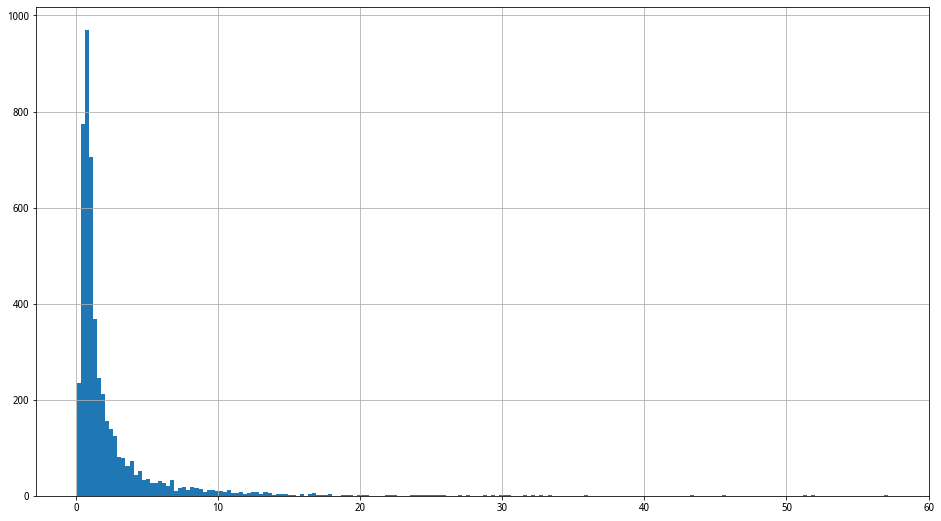

In [252]:
rule_cumret_by_crs.hist(bins=200)

In [144]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

rule_cumret
ret_mean     1.285308
t_values    24.791163

In [145]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.2853      0.052     24.789      0.000       2.184       2.387


平均年化收益：

In [253]:
# 1.29/(2021-2007+1)
2.29**(1/(2021-2007+1)) - 1

0.05679082026478244

### Cross-sectional test of mean daily return

In [254]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE    0.000126
000002.XSHE    0.000014
000004.XSHE    0.000027
000005.XSHE    0.000409
000006.XSHE    0.000257
000007.XSHE    0.000581
000008.XSHE    0.000701
000009.XSHE    0.000376
                 ...   
900949.XSHG   -0.000143
900950.XSHG    0.000669
900951.XSHG    0.000887
900952.XSHG    0.000204
900953.XSHG    0.000280
900955.XSHG    0.000249
900956.XSHG    0.000429
900957.XSHG    0.000550
Name: position_open_ret_demean, Length: 4870, dtype: float64

In [255]:
temp = stk_df[stk_df['secID']==np.random.choice(stk_df['secID'].unique(),1)[0]].copy()
temp['signal'] = 0
temp.loc[temp['closePrice'] > temp['EMA'], 'signal'] = 1
display(temp)
rule_return(temp)['position_open_ret_demean'].mean()

secID  tradeDate  preClosePrice  closePrice  openPrice  \
3951029  002976.XSHE 2020-03-06         19.010      27.370     22.810   
3951030  002976.XSHE 2020-03-09         27.370      30.110     30.110   
3951031  002976.XSHE 2020-03-10         30.110      33.120     33.120   
3951032  002976.XSHE 2020-03-11         33.120      36.430     36.430   
3951033  002976.XSHE 2020-03-12         36.430      40.070     40.070   
3951034  002976.XSHE 2020-03-13         40.070      44.080     44.080   
3951035  002976.XSHE 2020-03-16         44.080      48.490     48.490   
3951036  002976.XSHE 2020-03-17         48.490      48.770     53.340   
...              ...        ...            ...         ...        ...   
3951520  002976.XSHE 2022-03-15         25.451      23.813     25.072   
3951521  002976.XSHE 2022-03-16         23.813      24.706     23.960   
3951522  002976.XSHE 2022-03-17         24.706      25.623     25.060   
3951523  002976.XSHE 2022-03-18         25.623      25.708     25.635   
3951524  002976.XSHE 2022-03-21         25.708      25.867     25.843   
3951525  002976.XSHE 2022-03-22         25.867      25.733     25.671   
3951526  002976.XSHE 2022-03-23         25.733      26.429     25.733   
3951527  002976.XSHE 2022-03-24         26.429      25.953     26.466   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  \
3951029        27.370       22.810    6.842500e+08   2.038940e+06   
3951030        30.110       30.110    7.527500e+08   7.342022e+05   
3951031        33.120       33.120    8.280000e+08   9.052358e+05   
3951032        36.430       36.430    9.107500e+08   1.077344e+06   
3951033        40.070       40.070    1.001750e+09   8.518842e+06   
3951034        44.080       44.080    1.102000e+09   1.246358e+07   
3951035        48.490       48.490    1.212250e+09   7.822019e+06   
3951036        53.340       44.510    1.219250e+09   8.048023e+08   
...               ...          ...             ...            ...   
3951520        25.231       23.716    6.869622e+08   3.826424e+07   
3951521        24.791       23.728    7.127056e+08   3.287698e+07   
3951522        26.124       24.755    7.391544e+08   4.389931e+07   
3951523        26.283       25.635    7.416230e+08   2.176779e+07   
3951524        26.258       25.549    7.462074e+08   3.094849e+07   
3951525        26.099       25.354    7.423282e+08   2.561425e+07   
3951526        27.077       25.598    7.624293e+08   5.088399e+07   
3951527        26.894       25.916    7.486760e+08   3.830633e+07   

         turnoverRate        EMA  open_ret  close_ret  signal  
3951029        0.0030        NaN       NaN   0.439769       0  
3951030        0.0010        NaN  0.320035   0.100110       0  
3951031        0.0011        NaN  0.099967   0.099967       0  
3951032        0.0012        NaN  0.099940   0.099940       0  
3951033        0.0085        NaN  0.099918   0.099918       0  
3951034        0.0113        NaN  0.100075   0.100075       0  
3951035        0.0065        NaN  0.100045   0.100045       0  
3951036        0.6543        NaN  0.100021   0.005774       0  
...               ...        ...       ...        ...     ...  
3951520        0.0541  28.166318 -0.029346  -0.064359       0  
3951521        0.0470  27.836764 -0.044352   0.037501       0  
3951522        0.0596  27.625929  0.045910   0.037116       0  
3951523        0.0292  27.443269  0.022945   0.003317       0  
3951524        0.0415  27.293148  0.008114   0.006185       0  
3951525        0.0345  27.144563 -0.006656  -0.005180       0  
3951526        0.0669  27.076414  0.002415   0.027047       0  
3951527        0.0504  26.969422  0.028485  -0.018011       0  

[499 rows x 14 columns]

-0.00112367221951029

In [256]:
rule_tsmean_ret_by_crs['002976.XSHE']

-0.00112367221951029

In [257]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [258]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

rule_daily_ret
ret_mean       -0.000170
t_values      -14.688526

## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [259]:
EMA_ret_df

openIndex  closeIndex  open_ret  close_ret          EMA  signal  \
tradeDate                                                                     
2007-01-04  2073.2500   2067.0900       NaN   0.012758          NaN       0   
2007-01-05  2051.1500   2072.8800 -0.010660   0.002801          NaN       0   
2007-01-08  2072.0000   2131.5600  0.010165   0.028308          NaN       0   
2007-01-09  2137.4900   2200.0900  0.031607   0.032150          NaN       0   
2007-01-10  2210.7600   2255.9700  0.034279   0.025399          NaN       0   
2007-01-11  2257.0100   2231.6300  0.020920  -0.010789          NaN       0   
2007-01-12  2215.8600   2173.7500 -0.018232  -0.025936          NaN       0   
2007-01-15  2170.9400   2287.3400 -0.020272   0.052255          NaN       0   
...               ...         ...       ...        ...          ...     ...   
2022-03-18  4218.4736   4265.9017 -0.004530   0.006656  4360.013860       0   
2022-03-21  4280.1397   4258.7459  0.014618  -0.001677  4350.369293       0   
2022-03-22  4252.5658   4255.2950 -0.006442  -0.000810  4341.314598       0   
2022-03-23  4269.6088   4276.5174  0.004008   0.004987  4335.143436       0   
2022-03-24  4249.5328   4251.3061 -0.004702  -0.005895  4327.158928       0   
2022-03-25  4249.0731   4174.5742 -0.000108  -0.018049  4312.627049       0   
2022-03-28  4128.8379   4148.4663 -0.028297  -0.006254  4296.992692       0   
2022-03-29  4155.4182   4134.1441  0.006438  -0.003452  4281.483302       0   

            position_close  position_open  position_close_ret  \
tradeDate                                                       
2007-01-04               0            NaN                 NaN   
2007-01-05               0            0.0                 0.0   
2007-01-08               0            0.0                 0.0   
2007-01-09               0            0.0                 0.0   
2007-01-10               0            0.0                 0.0   
2007-01-11               0            0.0                -0.0   
2007-01-12               0            0.0                -0.0   
2007-01-15               0            0.0                 0.0   
...                    ...            ...                 ...   
2022-03-18               0            0.0                 0.0   
2022-03-21               0            0.0                -0.0   
2022-03-22               0            0.0                -0.0   
2022-03-23               0            0.0                 0.0   
2022-03-24               0            0.0                -0.0   
2022-03-25               0            0.0                -0.0   
2022-03-28               0            0.0                -0.0   
2022-03-29               0            0.0                -0.0   

            position_open_ret  position_close_ret_demean  \
tradeDate                                                  
2007-01-04                NaN                        NaN   
2007-01-05                NaN                        0.0   
2007-01-08                0.0                        0.0   
2007-01-09                0.0                        0.0   
2007-01-10                0.0                        0.0   
2007-01-11                0.0                       -0.0   
2007-01-12               -0.0                       -0.0   
2007-01-15               -0.0                        0.0   
...                       ...                        ...   
2022-03-18               -0.0                        0.0   
2022-03-21                0.0                       -0.0   
2022-03-22               -0.0                       -0.0   
2022-03-23                0.0                        0.0   
2022-03-24               -0.0                       -0.0   
2022-03-25               -0.0                       -0.0   
2022-03-28               -0.0                       -0.0   
2022-03-29                0.0                       -0.0   

            position_open_ret_demean  EMA_close_cumret  EMA_open_cumret  
tradeDate                                                  

In [260]:
rule_ret_series = EMA_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [261]:
n_sample

3703

In [262]:
rule_ret_series.mean()

0.0001432750113396586

In [263]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

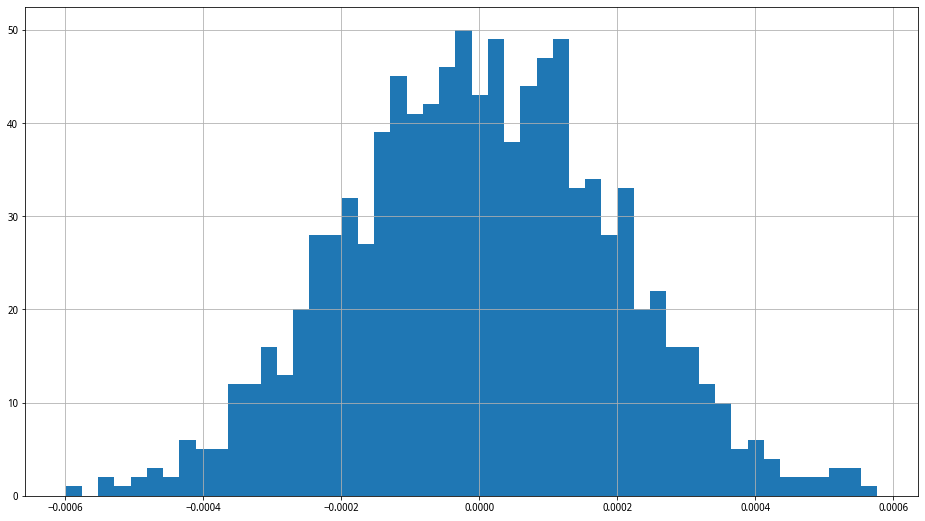

In [264]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [265]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum()

232

In [266]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.232

In [267]:
np.mean(rule_ret_series)

0.0001432750113396586

In [269]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [273]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.221

#### Test another stock

In [282]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [283]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

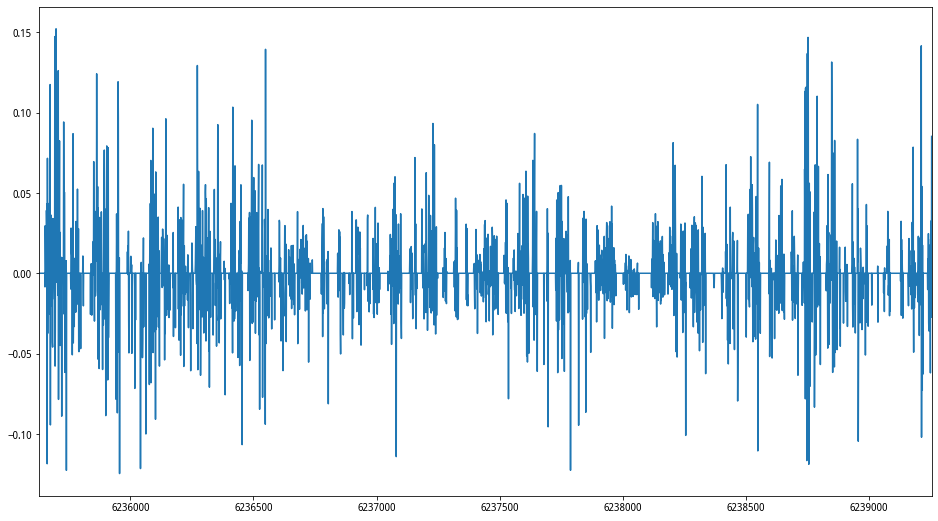

In [284]:
rule_ret_series.plot()

In [285]:
rule_ret_series.dropna(inplace=True)

In [287]:
white_reality_test(rule_ret_series)

0.479

#### Test 300 stocks

In [288]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [289]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [290]:
temp.dropna(inplace=True)

In [291]:
temp

secID  position_open_ret_demean  open_cumret
38193    000017.XSHE                      -0.0     1.000000
38194    000017.XSHE                       0.0     1.000000
38195    000017.XSHE                      -0.0     1.000000
38196    000017.XSHE                      -0.0     1.000000
38197    000017.XSHE                       0.0     1.000000
38198    000017.XSHE                      -0.0     1.000000
38199    000017.XSHE                       0.0     1.000000
38200    000017.XSHE                      -0.0     1.000000
...              ...                       ...          ...
9421263  900907.XSHG                      -0.0     4.953652
9421264  900907.XSHG                      -0.0     4.953652
9421265  900907.XSHG                      -0.0     4.953652
9421266  900907.XSHG                       0.0     4.953652
9421267  900907.XSHG                      -0.0     4.953652
9421268  900907.XSHG                      -0.0     4.953652
9421269  900907.XSHG                       0.0     4.953652
9421270  900907.XSHG                      -0.0     4.953652

[566220 rows x 3 columns]

In [292]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 42 s, sys: 12 ms, total: 42 s
Wall time: 42 s


In [293]:
stk_white_p

secID
000017.XSHE    0.251
000032.XSHE    0.459
000038.XSHE    0.473
000050.XSHE    0.322
000058.XSHE    0.410
000061.XSHE    0.407
000078.XSHE    0.080
000157.XSHE    0.142
               ...  
688579.XSHG    0.340
688611.XSHG    0.436
688711.XSHG    0.460
688737.XSHG    0.653
688767.XSHG    0.426
688788.XSHG    0.218
688798.XSHG    0.617
900907.XSHG    0.021
Name: position_open_ret_demean, Length: 300, dtype: float64

In [294]:
stk_white_p.describe()

count    285.000000
mean       0.527839
std        0.254886
min        0.001000
25%        0.331000
50%        0.513000
75%        0.751000
max        0.988000
Name: position_open_ret_demean, dtype: float64

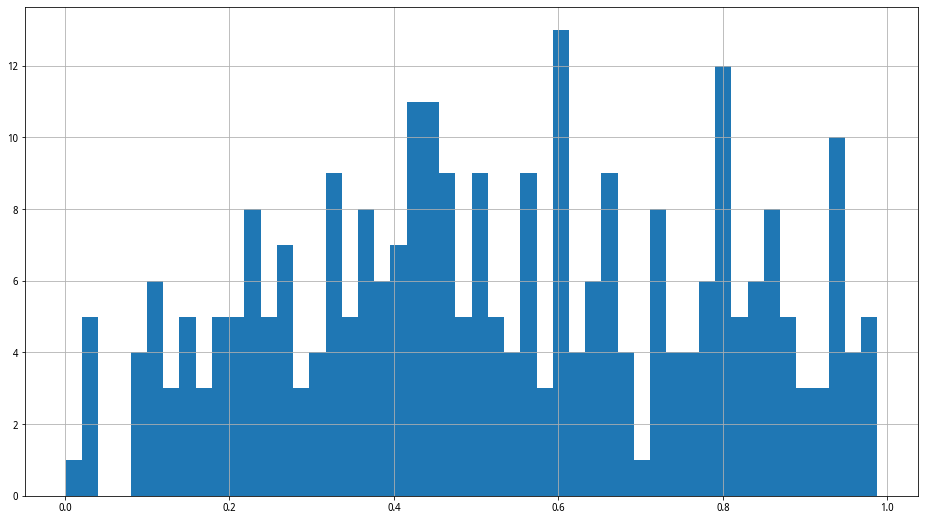

In [295]:
stk_white_p.hist(bins=50)

In [296]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000078.XSHE    0.080
002092.XSHE    0.095
002208.XSHE    0.097
002220.XSHE    0.001
002450.XSHE    0.025
200413.XSHE    0.031
600166.XSHG    0.099
601825.XSHG    0.026
603555.XSHG    0.030
900907.XSHG    0.021
Name: position_open_ret_demean, dtype: float64

In [297]:
good_EMA_stks = stk_white_p.loc[stk_white_p < 0.10].index

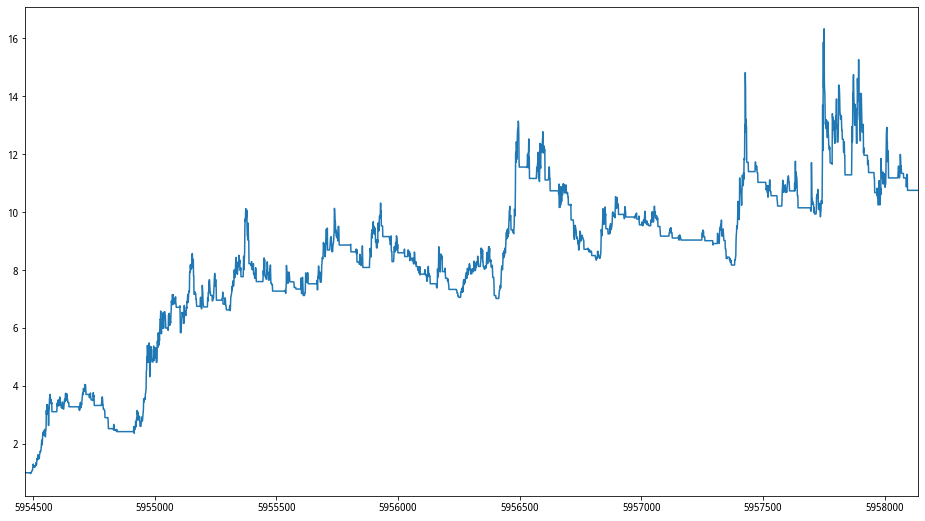

In [299]:
rule_ret_df.loc[rule_ret_df['secID']=='600166.XSHG','open_cumret'].plot()

In [300]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks[0:5])].reset_index(drop=True)

secID  position_open_ret_demean  open_cumret
0      000078.XSHE                       NaN          NaN
1      000078.XSHE                       NaN          NaN
2      000078.XSHE                       0.0     1.000000
3      000078.XSHE                       0.0     1.000000
4      000078.XSHE                      -0.0     1.000000
5      000078.XSHE                       0.0     1.000000
6      000078.XSHE                       0.0     1.000000
7      000078.XSHE                      -0.0     1.000000
...            ...                       ...          ...
15056  002450.XSHE                      -0.0     3.112926
15057  002450.XSHE                      -0.0     3.112926
15058  002450.XSHE                      -0.0     3.112926
15059  002450.XSHE                      -0.0     3.112926
15060  002450.XSHE                      -0.0     3.112926
15061  002450.XSHE                       0.0     3.112926
15062  002450.XSHE                      -0.0     3.112926
15063  002450.XSHE                       0.0     3.112926

[15064 rows x 3 columns]

In [301]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks)].copy()

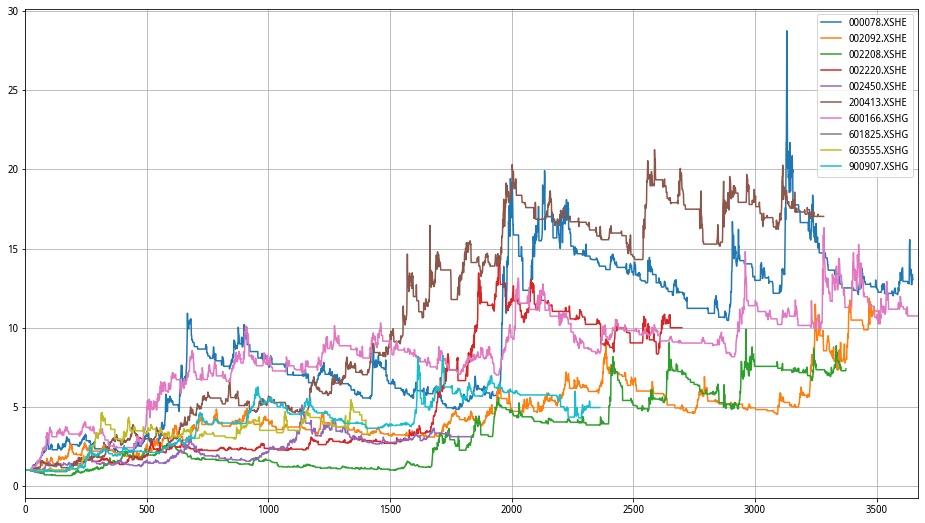

In [302]:
pd.concat({k: g.reset_index(drop=True) for k, g in temp2.groupby('secID')['open_cumret']}, axis=1).plot(grid=True)

# MACD

Moving Average Convergence Divergence (MACD)

$$MACD = EMA_{\text{fast period}} - EMA_{\text{slow period}}$$

$$E M A_t(\text{Value})= \left(\text { Value }_t *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) + E M A_{t-1} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)$$

$Smoothing = 2$, $\text{fast period} = 12$, $\text{slow period} = 26$. 第一个$EMA$用简单平均。比如，计算$EMA_{\text{12 period}}$，那么就等有12个观测值之后，取简单平均得到$EMA_1$，然后$EMA_2$用上述公式计算。

按照级数展开可发现，越靠近当前的价格，权重越大。Smoothing越大，越靠近当前价格的权重越大。

得到 MACD 以后，再计算 MACD 的 Signal，

$$Signal = EMA_{\text{9 period}}(MACD) $$

判断标准：当 MACD 上穿 Signal 时，处于上升趋势。当 MACD 下穿 Signal 时，处于下降趋势。

In [303]:
MACD_df = hs300_df.copy()

In [304]:
fastperiod = 12  
slowperiod = 26  
signalperiod = 9 

In [305]:
MACD_df

indexID secShortName   tradeDate  openIndex  highestIndex  \
0     000300.ZICN        沪深300  2007-01-04  2073.2500     2139.4900   
1     000300.ZICN        沪深300  2007-01-05  2051.1500     2083.4000   
2     000300.ZICN        沪深300  2007-01-08  2072.0000     2131.7400   
3     000300.ZICN        沪深300  2007-01-09  2137.4900     2201.3600   
4     000300.ZICN        沪深300  2007-01-10  2210.7600     2255.9700   
5     000300.ZICN        沪深300  2007-01-11  2257.0100     2289.9500   
6     000300.ZICN        沪深300  2007-01-12  2215.8600     2249.5400   
7     000300.ZICN        沪深300  2007-01-15  2170.9400     2287.6800   
...           ...          ...         ...        ...           ...   
3697  000300.ZICN        沪深300  2022-03-18  4218.4736     4283.3679   
3698  000300.ZICN        沪深300  2022-03-21  4280.1397     4287.8166   
3699  000300.ZICN        沪深300  2022-03-22  4252.5658     4283.3344   
3700  000300.ZICN        沪深300  2022-03-23  4269.6088     4287.5771   
3701  000300.ZICN        沪深300  2022-03-24  4249.5328     4273.9568   
3702  000300.ZICN        沪深300  2022-03-25  4249.0731     4254.8449   
3703  000300.ZICN        沪深300  2022-03-28  4128.8379     4174.1206   
3704  000300.ZICN        沪深300  2022-03-29  4155.4182     4177.2134   

      lowestIndex  closeIndex  turnoverVol  turnoverValue  close_ret  \
0       2054.2400   2067.0900  10671970700   8.238107e+10   0.012758   
1       2030.7600   2072.8800   9274344700   6.802606e+10   0.002801   
2       2071.7200   2131.5600   8476790900   6.630394e+10   0.028308   
3       2128.0600   2200.0900   8157762900   6.545619e+10   0.032150   
4       2194.7700   2255.9700   8490497900   6.882262e+10   0.025399   
5       2224.3700   2231.6300   8627654800   6.873001e+10  -0.010789   
6       2159.7700   2173.7500   7652572000   6.174283e+10  -0.025936   
7       2170.9400   2287.3400   6640309700   5.704345e+10   0.052255   
...           ...         ...          ...            ...        ...   
3697    4194.9402   4265.9017  14945830500   2.757913e+11   0.006656   
3698    4223.0240   4258.7459  12703636000   2.512145e+11  -0.001677   
3699    4236.6888   4255.2950  12638247000   2.262135e+11  -0.000810   
3700    4241.9570   4276.5174  11708907800   2.263908e+11   0.004987   
3701    4216.8506   4251.3061  10891827200   2.195944e+11  -0.005895   
3702    4173.9300   4174.5742  10880804600   2.170132e+11  -0.018049   
3703    4091.2978   4148.4663  11844902100   2.134690e+11  -0.006254   
3704    4124.7179   4134.1441  10026697200   1.994639e+11  -0.003452   

      open_ret  close_ret_demean  open_ret_demean  
0          NaN          0.012421              NaN  
1    -0.010660          0.002464        -0.011019  
2     0.010165          0.027971         0.009805  
3     0.031607          0.031813         0.031247  
4     0.034279          0.025062         0.033919  
5     0.020920         -0.011126         0.020561  
6    -0.018232         -0.026273        -0.018592  
7    -0.020272          0.051918        -0.020632  
...        ...               ...              ...  
3697 -0.004530          0.006319        -0.004890  
3698  0.014618         -0.002014         0.014258  
3699 -0.006442         -0.001147        -0.006802  
3700  0.004008          0.004650         0.003648  
3701 -0.004702         -0.006232        -0.005062  
3702 -0.000108         -0.018386        -0.000468  
3703 -0.028297         -0.006591        -0.028657  
3704  0.006438         -0.003789         0.006078  

[3705 rows x 13 columns]

In [306]:
MACD_df['MACD'], MACD_df['MACD_signal'], _ = ta.MACD(MACD_df['closeIndex'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)

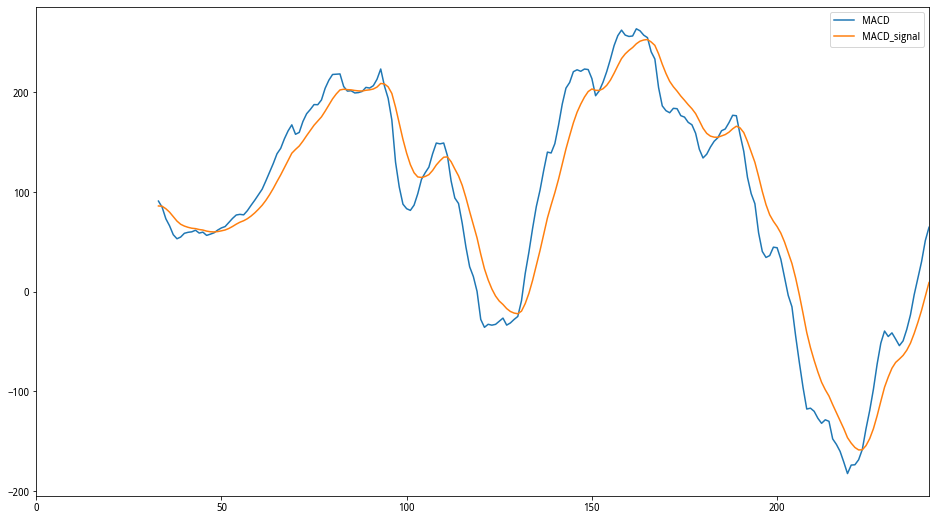

In [307]:
MACD_df.loc[MACD_df['tradeDate']<='2007-12-31',['MACD','MACD_signal']].plot()

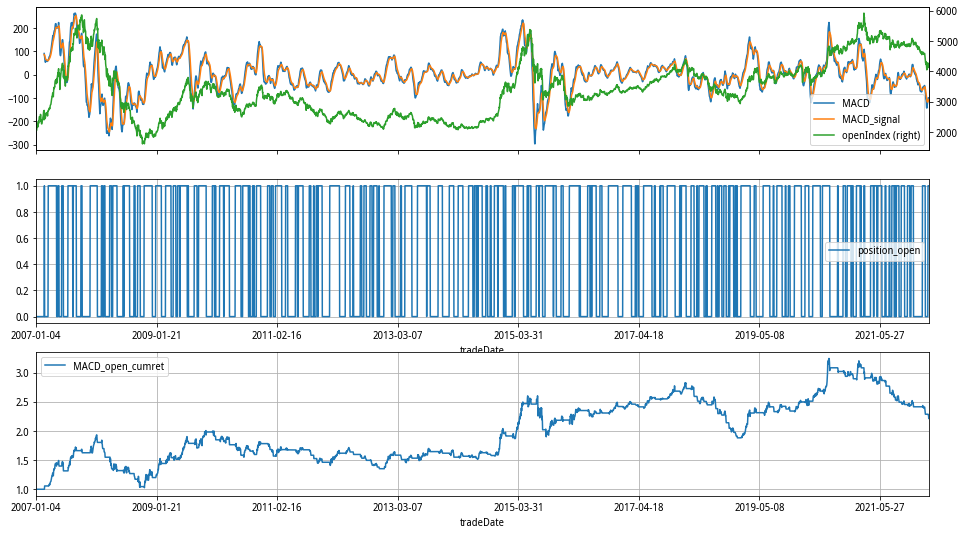

In [308]:
MACD_df['signal'] = 0
MACD_df.loc[MACD_df['MACD'] > MACD_df['MACD_signal'], 'signal'] = 1
MACD_df['open_ret'] = MACD_df['openIndex']/MACD_df['openIndex'].shift()-1
MACD_df['position_close'] = MACD_df['signal']
MACD_df['position_open'] = MACD_df['signal'].shift()
MACD_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MACD_df['position_close_ret'] = MACD_df['position_close'].shift() * MACD_df['close_ret']
MACD_df['position_open_ret'] = MACD_df['position_open'].shift() * MACD_df['open_ret']
MACD_df['position_close_ret_demean'] = MACD_df['position_close'].shift() * MACD_df['close_ret_demean']
MACD_df['position_open_ret_demean'] = MACD_df['position_open'].shift() * MACD_df['open_ret_demean']
MACD_df['MACD_close_cumret'] = (MACD_df['position_close_ret']+1).cumprod()
MACD_df['MACD_open_cumret'] = (MACD_df['position_open_ret']+1).cumprod()
MACD_ret_df = MACD_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MACD','MACD_signal',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'MACD_close_cumret','MACD_open_cumret']].copy()
MACD_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
MACD_ret_df[['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df[['openIndex']].plot(secondary_y=True,ax=axes[0])
MACD_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df[['MACD_open_cumret']].plot(ax=axes[2], grid=True)

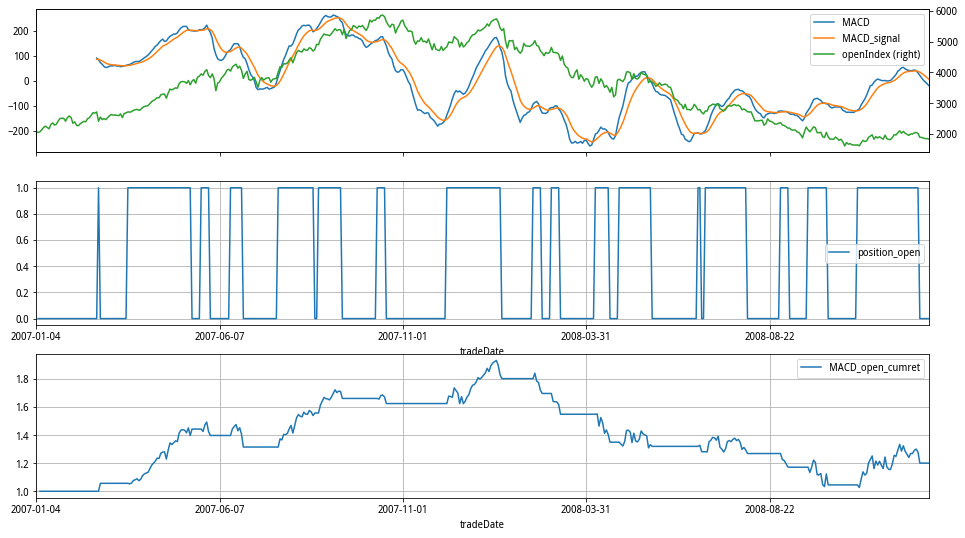

In [309]:
fig, axes = plt.subplots(3,1)
MACD_ret_df.loc[:'2009',['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df.loc[:'2009',['openIndex']].plot(secondary_y=True,ax=axes[0])
MACD_ret_df.loc[:'2009',['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df.loc[:'2009',['MACD_open_cumret']].plot(ax=axes[2], grid=True)

## Cross-sectional test

In [310]:
stk_df

secID  tradeDate  preClosePrice  closePrice  openPrice  \
85       000001.XSHE 2007-06-20        824.193     987.007   1044.285   
86       000001.XSHE 2007-06-21        987.007    1085.740   1026.564   
87       000001.XSHE 2007-06-22       1085.740    1120.233   1126.562   
88       000001.XSHE 2007-06-25       1120.233    1113.904   1139.536   
89       000001.XSHE 2007-06-27       1113.904    1019.602   1002.513   
90       000001.XSHE 2007-06-28       1019.602     953.780    996.817   
91       000001.XSHE 2007-06-29        953.780     870.870    943.021   
92       000001.XSHE 2007-07-02        870.870     867.073    848.402   
...              ...        ...            ...         ...        ...   
9972174  900957.XSHG 2022-03-15          0.594       0.539      0.592   
9972175  900957.XSHG 2022-03-16          0.539       0.575      0.549   
9972176  900957.XSHG 2022-03-17          0.575       0.578      0.580   
9972177  900957.XSHG 2022-03-18          0.578       0.580      0.578   
9972178  900957.XSHG 2022-03-21          0.580       0.583      0.584   
9972179  900957.XSHG 2022-03-22          0.583       0.578      0.578   
9972180  900957.XSHG 2022-03-23          0.578       0.581      0.578   
9972181  900957.XSHG 2022-03-24          0.581       0.583      0.585   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  \
85           1053.778      970.235    4.835036e+10   4.182345e+09   
86           1085.740      988.906    5.318694e+10   2.285485e+09   
87           1132.891     1069.601    5.487665e+10   2.761567e+09   
88           1157.574     1087.005    5.456661e+10   2.324186e+09   
89           1069.284     1002.513    4.994705e+10   2.446556e+09   
90           1024.348      950.299    4.672266e+10   1.617434e+09   
91            948.717      861.377    4.266117e+10   1.410758e+09   
92            881.629      840.807    4.247515e+10   8.756147e+08   
...               ...          ...             ...            ...   
9972174         0.592        0.539    9.844000e+07   3.858820e+05   
9972175         0.580        0.549    1.048800e+08   3.278910e+05   
9972176         0.589        0.575    1.054320e+08   1.566370e+05   
9972177         0.580        0.575    1.058000e+08   3.270200e+04   
9972178         0.584        0.576    1.063520e+08   5.280900e+04   
9972179         0.583        0.575    1.054320e+08   8.467200e+04   
9972180         0.585        0.578    1.059840e+08   4.250300e+04   
9972181         0.585        0.579    1.063520e+08   1.823400e+04   

         turnoverRate       EMA  open_ret  close_ret  signal  
85             0.0840       NaN       NaN   0.197544       0  
86             0.0440       NaN -0.016970   0.100033       0  
87             0.0510       NaN  0.097410   0.031769       0  
88             0.0426       NaN  0.011516  -0.005650       0  
89             0.0489       NaN -0.120245  -0.084659       0  
90             0.0336       NaN -0.005682  -0.064557       0  
91             0.0316       NaN -0.053968  -0.086928       0  
92             0.0209       NaN -0.100336  -0.004360       0  
...               ...       ...       ...        ...     ...  
9972174        0.0037  0.605024 -0.019868  -0.092593       0  
9972175        0.0032  0.602165 -0.072635   0.066790       0  
9972176        0.0015  0.599863  0.056466   0.005217       0  
9972177        0.0003  0.597972 -0.003448   0.003460       0  
9972178        0.0005  0.596546  0.010381   0.005172       0  
9972179        0.0008  0.594780 -0.010274  -0.008576       0  
9972180        0.0004  0.593467  0.000000   0.005190       0  
9972181        0.0002  0.592470  0.012111   0.003442       0  

[9572273 rows x 14 columns]

In [311]:
stk_df.drop('EMA',axis=1,inplace=True)

In [312]:
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_signal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])

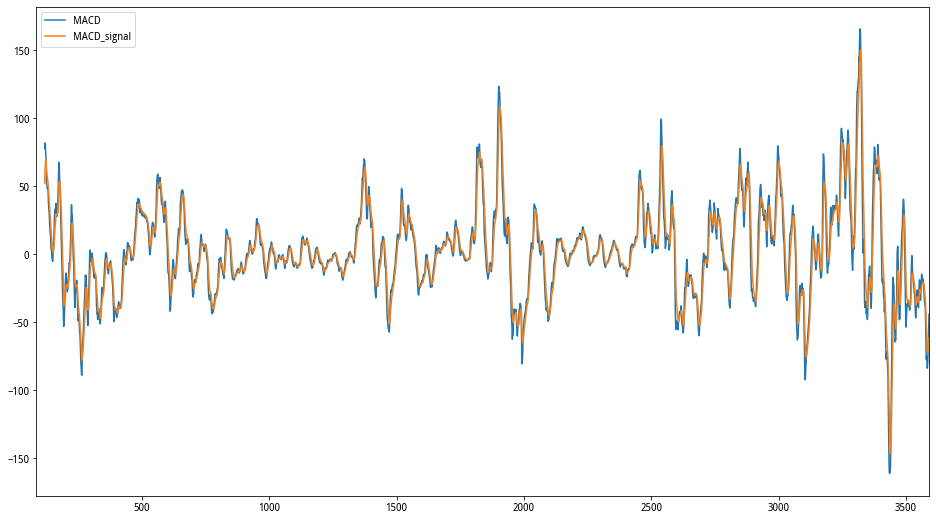

In [313]:
stk_df.loc[stk_df['secID']=='000001.XSHE',['MACD','MACD_signal']].plot()

In [314]:
stk_df['signal'] = 0
stk_df.loc[stk_df['MACD'] > stk_df['MACD_signal'], 'signal'] = 1

In [315]:
stk_df

secID  tradeDate  preClosePrice  closePrice  openPrice  \
85       000001.XSHE 2007-06-20        824.193     987.007   1044.285   
86       000001.XSHE 2007-06-21        987.007    1085.740   1026.564   
87       000001.XSHE 2007-06-22       1085.740    1120.233   1126.562   
88       000001.XSHE 2007-06-25       1120.233    1113.904   1139.536   
89       000001.XSHE 2007-06-27       1113.904    1019.602   1002.513   
90       000001.XSHE 2007-06-28       1019.602     953.780    996.817   
91       000001.XSHE 2007-06-29        953.780     870.870    943.021   
92       000001.XSHE 2007-07-02        870.870     867.073    848.402   
...              ...        ...            ...         ...        ...   
9972174  900957.XSHG 2022-03-15          0.594       0.539      0.592   
9972175  900957.XSHG 2022-03-16          0.539       0.575      0.549   
9972176  900957.XSHG 2022-03-17          0.575       0.578      0.580   
9972177  900957.XSHG 2022-03-18          0.578       0.580      0.578   
9972178  900957.XSHG 2022-03-21          0.580       0.583      0.584   
9972179  900957.XSHG 2022-03-22          0.583       0.578      0.578   
9972180  900957.XSHG 2022-03-23          0.578       0.581      0.578   
9972181  900957.XSHG 2022-03-24          0.581       0.583      0.585   

         highestPrice  lowestPrice  negMarketValue  turnoverValue  \
85           1053.778      970.235    4.835036e+10   4.182345e+09   
86           1085.740      988.906    5.318694e+10   2.285485e+09   
87           1132.891     1069.601    5.487665e+10   2.761567e+09   
88           1157.574     1087.005    5.456661e+10   2.324186e+09   
89           1069.284     1002.513    4.994705e+10   2.446556e+09   
90           1024.348      950.299    4.672266e+10   1.617434e+09   
91            948.717      861.377    4.266117e+10   1.410758e+09   
92            881.629      840.807    4.247515e+10   8.756147e+08   
...               ...          ...             ...            ...   
9972174         0.592        0.539    9.844000e+07   3.858820e+05   
9972175         0.580        0.549    1.048800e+08   3.278910e+05   
9972176         0.589        0.575    1.054320e+08   1.566370e+05   
9972177         0.580        0.575    1.058000e+08   3.270200e+04   
9972178         0.584        0.576    1.063520e+08   5.280900e+04   
9972179         0.583        0.575    1.054320e+08   8.467200e+04   
9972180         0.585        0.578    1.059840e+08   4.250300e+04   
9972181         0.585        0.579    1.063520e+08   1.823400e+04   

         turnoverRate  open_ret  close_ret  signal      MACD  MACD_signal  
85             0.0840       NaN   0.197544       0       NaN          NaN  
86             0.0440 -0.016970   0.100033       0       NaN          NaN  
87             0.0510  0.097410   0.031769       0       NaN          NaN  
88             0.0426  0.011516  -0.005650       0       NaN          NaN  
89             0.0489 -0.120245  -0.084659       0       NaN          NaN  
90             0.0336 -0.005682  -0.064557       0       NaN          NaN  
91             0.0316 -0.053968  -0.086928       0       NaN          NaN  
92             0.0209 -0.100336  -0.004360       0       NaN          NaN  
...               ...       ...        ...     ...       ...          ...  
9972174        0.0037 -0.019868  -0.092593       0 -0.012289    -0.007350  
9972175        0.0032 -0.072635   0.066790       0 -0.013116    -0.008503  
9972176        0.0015  0.056466   0.005217       0 -0.013375    -0.009478  
9972177        0.0003 -0.003448   0.003460       0 -0.013265    -0.010235  
9972178        0.0005  0.010381   0.005172       0 -0.012789    -0.010746  
9972179        0.0008 -0.010274  -0.008576       0 -0.012670    -0.011131  
9972180        0.0004  0.000000   0.005190       0 -0.012192    -0.011343  
9972181        0.0002  0.012111   0.003442       0 -0.011519    -0.011378  

[9572273 rows x 15 columns]

In [319]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 50.4 s, sys: 7.66 s, total: 58.1 s
Wall time: 58 s


In [320]:
rule_ret_df.reset_index(inplace=True)

In [321]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [322]:
rule_ret_df

secID  position_open_ret_demean  open_cumret
0        000001.XSHE                       NaN          NaN
1        000001.XSHE                       NaN          NaN
2        000001.XSHE                       0.0     1.000000
3        000001.XSHE                       0.0     1.000000
4        000001.XSHE                      -0.0     1.000000
5        000001.XSHE                      -0.0     1.000000
6        000001.XSHE                      -0.0     1.000000
7        000001.XSHE                      -0.0     1.000000
...              ...                       ...          ...
9572265  900957.XSHG                      -0.0     5.913241
9572266  900957.XSHG                      -0.0     5.913241
9572267  900957.XSHG                       0.0     5.913241
9572268  900957.XSHG                      -0.0     5.913241
9572269  900957.XSHG                       0.0     5.913241
9572270  900957.XSHG                      -0.0     5.913241
9572271  900957.XSHG                      -0.0     5.913241
9572272  900957.XSHG                       0.0     5.913241

[9572273 rows x 3 columns]

### Cross-sectional test of cumulative return

In [323]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [324]:
rule_cumret_by_crs

secID
000001.XSHE     0.997932
000002.XSHE     2.032307
000004.XSHE     5.603435
000005.XSHE     2.925598
000006.XSHE     8.728217
000007.XSHE     3.184457
000008.XSHE     3.766304
000009.XSHE    13.714785
                 ...    
900949.XSHG     1.174942
900950.XSHG    24.144682
900951.XSHG     2.809044
900952.XSHG     1.395101
900953.XSHG     8.109407
900955.XSHG     2.425378
900956.XSHG     6.548926
900957.XSHG     5.913241
Name: open_cumret, Length: 4870, dtype: float64

In [325]:
rule_cumret_by_crs.describe()

count    4867.000000
mean        2.112790
std         2.891073
min         0.051403
25%         0.754067
50%         1.155554
75%         2.261017
max        54.251026
Name: open_cumret, dtype: float64

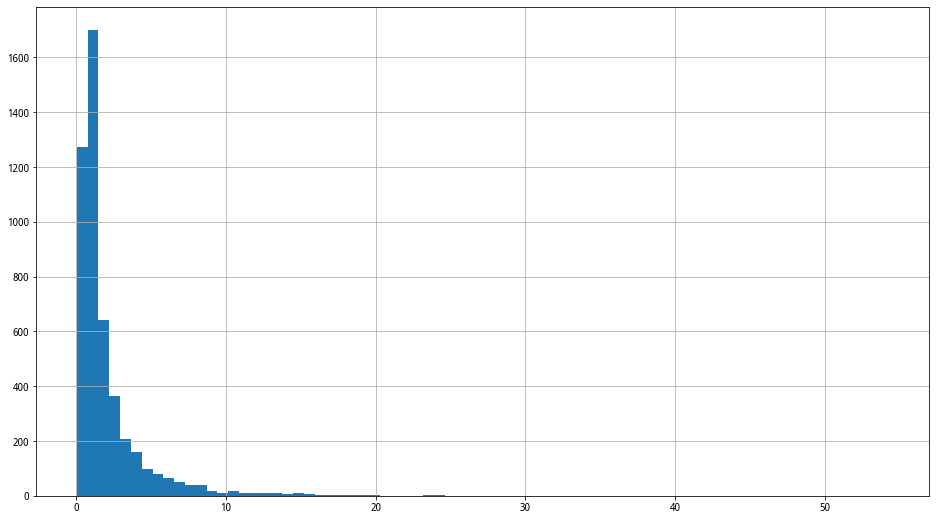

In [326]:
rule_cumret_by_crs.hist(bins=75)

In [327]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

rule_cumret
ret_mean     1.112790
t_values    26.855267

In [328]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1128      0.041     26.853      0.000       2.032       2.194


平均年化收益：

In [329]:
2.1128**(1/(2021-2007+1))-1

0.05113192304296499

### Cross-sectional test of mean daily return

In [330]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE   -0.000105
000002.XSHE    0.000002
000004.XSHE    0.000625
000005.XSHE    0.000507
000006.XSHE    0.000471
000007.XSHE    0.000582
000008.XSHE    0.000331
000009.XSHE    0.000639
                 ...   
900949.XSHG   -0.000112
900950.XSHG    0.001013
900951.XSHG    0.000441
900952.XSHG    0.000118
900953.XSHG    0.000618
900955.XSHG    0.000397
900956.XSHG    0.000271
900957.XSHG    0.000384
Name: position_open_ret_demean, Length: 4870, dtype: float64

In [331]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [332]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

rule_daily_ret
ret_mean       -0.000108
t_values      -10.463987

## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [333]:
rule_ret_series = MACD_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [334]:
n_sample

3703

In [335]:
rule_ret_series.mean()

0.00010363303159712488

In [336]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

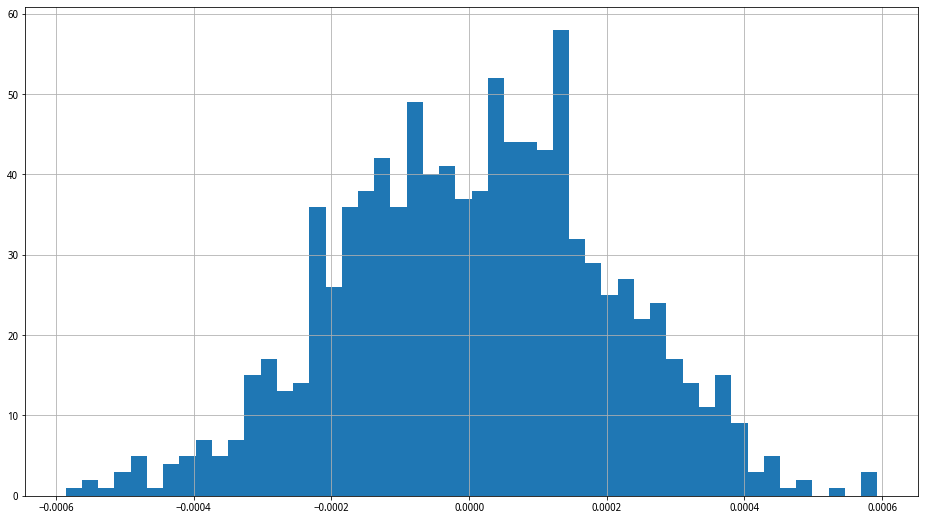

In [337]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [338]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.327

In [339]:
np.mean(rule_ret_series)

0.00010363303159712488

In [340]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [342]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.299

#### Test another stock

In [278]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [279]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

In [280]:
rule_ret_series.dropna(inplace=True)

In [287]:
white_reality_test(rule_ret_series)

0.123

#### Test 300 stocks

In [288]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [289]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [290]:
temp.dropna(inplace=True)

In [291]:
temp

secID  position_open_ret_demean  open_cumret
47301    000021.XSHE                  0.000000     1.000000
47302    000021.XSHE                  0.000000     1.000000
47303    000021.XSHE                  0.000000     1.000000
47304    000021.XSHE                  0.000000     1.000000
47305    000021.XSHE                  0.000000     1.000000
47306    000021.XSHE                 -0.000000     1.000000
47307    000021.XSHE                  0.000000     1.000000
47308    000021.XSHE                  0.000000     1.000000
...              ...                       ...          ...
9568574  900956.XSHG                 -0.010166     6.548926
9568575  900956.XSHG                 -0.000000     6.548926
9568576  900956.XSHG                  0.000000     6.548926
9568577  900956.XSHG                 -0.000000     6.548926
9568578  900956.XSHG                  0.000000     6.548926
9568579  900956.XSHG                  0.000000     6.548926
9568580  900956.XSHG                  0.000000     6.548926
9568581  900956.XSHG                 -0.000000     6.548926

[598751 rows x 3 columns]

In [292]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 39.9 s, sys: 16 ms, total: 39.9 s
Wall time: 39.9 s


In [293]:
stk_white_p

secID
000021.XSHE    0.609
000042.XSHE    0.545
000070.XSHE    0.251
000157.XSHE    0.603
000515.XSHE    0.659
000576.XSHE    0.117
000651.XSHE    0.447
000662.XSHE    0.202
               ...  
900914.XSHG    0.196
900920.XSHG    0.316
900923.XSHG    0.046
900929.XSHG    0.090
900930.XSHG    0.449
900941.XSHG    0.328
900942.XSHG    0.117
900956.XSHG    0.255
Name: position_open_ret_demean, Length: 300, dtype: float64

In [294]:
stk_white_p.describe()

count    296.000000
mean       0.535669
std        0.256107
min        0.015000
25%        0.329500
50%        0.530500
75%        0.728250
max        0.996000
Name: position_open_ret_demean, dtype: float64

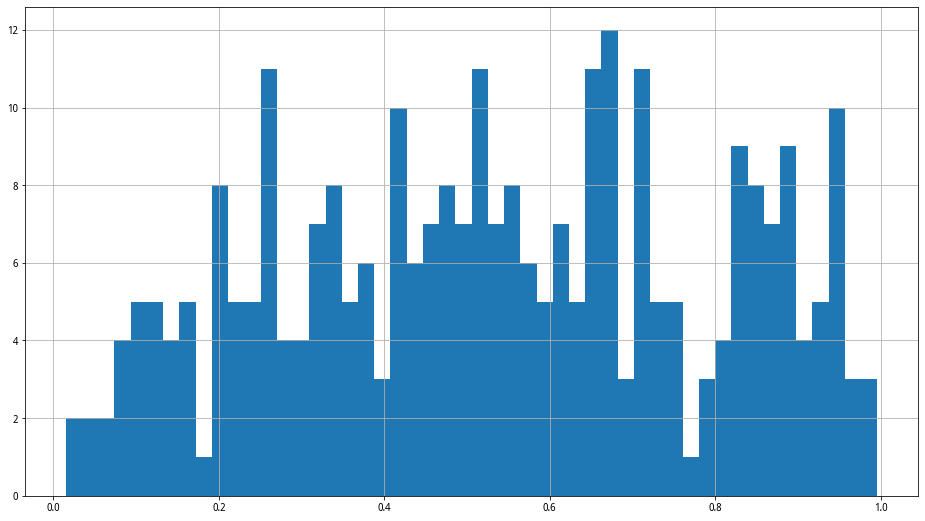

In [295]:
stk_white_p.hist(bins=50)

In [296]:
stk_white_p.loc[stk_white_p < 0.10]

secID
002092.XSHE    0.088
200054.XSHE    0.015
300110.XSHE    0.080
300140.XSHE    0.060
600538.XSHG    0.087
600827.XSHG    0.033
688191.XSHG    0.053
900907.XSHG    0.073
900923.XSHG    0.046
900929.XSHG    0.090
Name: position_open_ret_demean, dtype: float64

In [297]:
good_MACD_stks = stk_white_p.loc[stk_white_p < 0.10].index

In [298]:
rule_ret_df.loc[rule_ret_df['secID']=='688191.XSHG','open_cumret']

9325699         NaN
9325700         NaN
9325701    1.000000
9325702    1.000000
9325703    1.000000
9325704    1.000000
9325705    1.000000
9325706    1.000000
             ...   
9325925    1.750436
9325926    1.750436
9325927    1.750436
9325928    1.750436
9325929    1.750436
9325930    1.750436
9325931    1.750436
9325932    1.750436
Name: open_cumret, Length: 234, dtype: float64

In [299]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks[0:5])].reset_index(drop=True)

secID  position_open_ret_demean  open_cumret
0      002092.XSHE                       NaN          NaN
1      002092.XSHE                       NaN          NaN
2      002092.XSHE                  0.000000     1.000000
3      002092.XSHE                  0.000000     1.000000
4      002092.XSHE                  0.000000     1.000000
5      002092.XSHE                 -0.000000     1.000000
6      002092.XSHE                  0.000000     1.000000
7      002092.XSHE                 -0.000000     1.000000
...            ...                       ...          ...
14551  600538.XSHG                 -0.000000    13.428978
14552  600538.XSHG                 -0.000000    13.428978
14553  600538.XSHG                  0.000000    13.428978
14554  600538.XSHG                  0.000000    13.428978
14555  600538.XSHG                  0.000000    13.428978
14556  600538.XSHG                  0.000000    13.428978
14557  600538.XSHG                 -0.019607    13.180785
14558  600538.XSHG                 -0.004916    13.130825

[14559 rows x 3 columns]

In [300]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks)].copy()

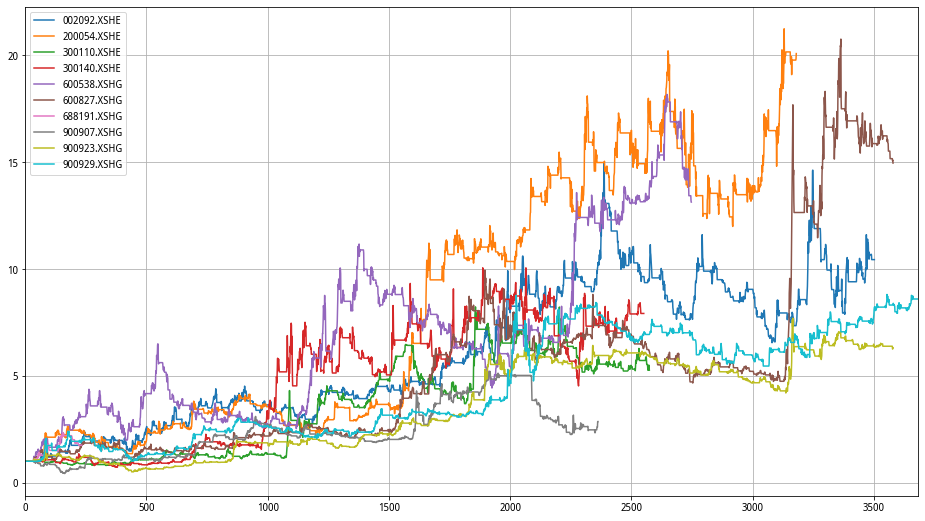

In [301]:
pd.concat({k: g.reset_index(drop=True) for k, g in temp2.groupby('secID')['open_cumret']}, axis=1).plot(grid=True)